In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import scanpy as sc
import scrna

from matplotlib import pyplot as plt
from matplotlib import rcParams
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import cuml

In [3]:
adata = sc.read_h5ad("/storage/codex/datasets_v1/bladder_merged.h5ad")
features = [f'{v}_membrane_mean' for v in adata.uns['channels'] if 'DAPI' not in v]

toss_spots = [
    '210226_Bladder_TMA1_reg35_v5', 
]
adata = adata[~adata.obs.sample_id.isin(toss_spots)].copy()
adata

AnnData object with n_obs × n_vars = 615171 × 1440
    obs: 'CD45_ringpct', 'CD20_ringpct', 'CD3e_ringpct', 'CD45RO_ringpct', 'CD45RA_ringpct', 'CD8_ringpct', 'CD4_ringpct', 'CDH12_ringpct', 'KRT13_ringpct', 'KRT17_ringpct', 'PanCytoK_ringpct', 'ERBB2_ringpct', 'sample_id', 'sample_id_printing', 'snSeq_sample', 'patient', 'biopsy'
    uns: 'channels', 'patient_colors', 'sample_id_printing_colors', 'sample_layout', 'snSeq_sample_colors'
    obsm: 'coordinates', 'coordinates_shift'

In [4]:
adata.uns['channels']

array(['DAPI', 'aSMA', 'CD45', 'PDGFRb', 'CD49a', 'CD68', 'CD31', 'CD103',
       'HLA-DR', 'UPK3', 'GATA3', 'CD3e', 'Ki-67', 'CDH18', 'CDH12',
       'KRT13', 'KRT17', 'CK5-6', 'CDH1', 'PD-1', 'CD11c', 'KRT20',
       'CD69', 'PD-L2', 'CD20', 'PD-L1', 'FOXP3', 'ERBB2', 'GZMB', 'CD44',
       'CD45RO', 'LAG3', 'CD45RA', 'CD8', 'CD4', 'PanCytoK'], dtype=object)

In [5]:
cell_sets = {}

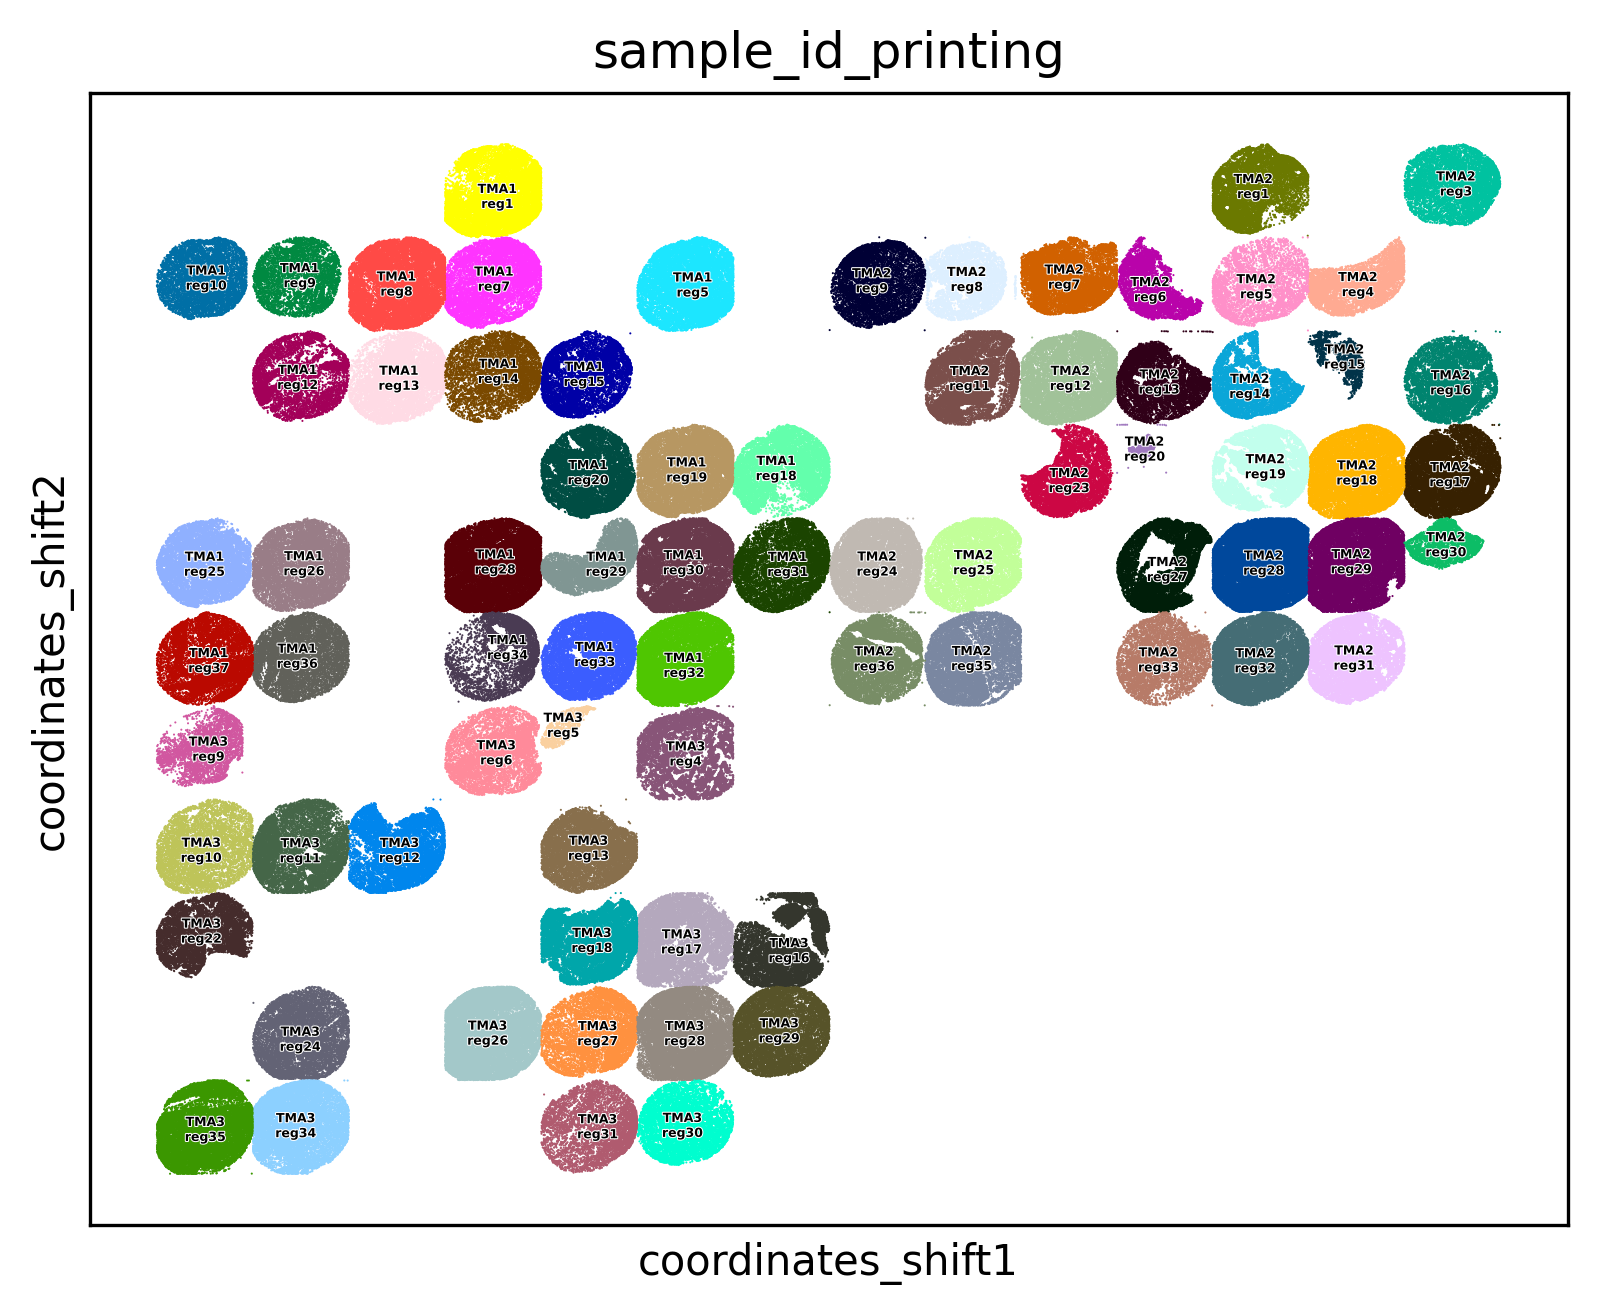

In [6]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['figure.dpi'] = 300
rcParams['figure.facecolor'] = (1,1,1,1)

r = np.max(np.abs(adata.obsm['coordinates_shift']), axis=0)
r = r[0]/r[1]
plt.figure(figsize=(r*5,5)) 
sc.pl.embedding(adata, basis='coordinates_shift', color='sample_id_printing', 
                legend_fontoutline=0.5,
                ax=plt.gca(),  
                legend_loc='on data', 
                legend_fontsize=3,
                s=1)

612670


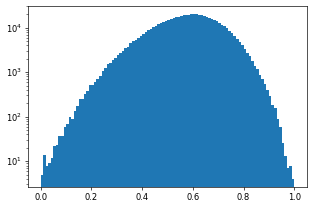

In [7]:
rcParams['figure.dpi'] = 60
f1 = 'DAPI_nuclei_mean'
v1 = np.log1p(adata[:,f1].X.toarray())
v1 = MinMaxScaler().fit_transform(v1).flatten()
_ = plt.hist(v1, bins=100, log=True)

dapi_filter = v1 > 0.2
print(dapi_filter.sum())
dapi_pass = np.zeros(adata.shape[0], dtype=object)
dapi_pass[:] = 'Pass'
dapi_pass[~dapi_filter] = 'Fail'
adata.obs['Filtered_DAPI'] = pd.Categorical(dapi_pass)

# sc.pl.heatmap(adata[adata.obs.Filtered_DAPI=='Fail'], features, groupby='sample_id', log=True,
#               standard_scale='var')
cell_sets['low_DAPI'] = ~dapi_filter

In [8]:
rcParams['svg.fonttype'] = 'none'
def feature_histogram(adata, f1, f2, mask, vmax=10, rcut=np.log10(5+1), v1cut=0.2, v2cut=0.2,
                      f1_fn=np.sum, f2_fn=np.sum, scaled=False, 
                      return_features=False,
                      ft_suffix='membrane_mean',
                      save=None
                     ):
    xlabel = ''
    for i,f in enumerate(f1.split(',')):
        xlabel += f'{f}'
        if (i+1)%3==0:
            xlabel+=' +\n'
        else:
            xlabel+=' + '
    xlabel = xlabel.strip('+ ')
    
    ylabel = ''
    for i,f in enumerate(f2.split(',')):
        ylabel += f'{f}'
        if (i+1)%3==0:
            ylabel+=' +\n'
        else:
            ylabel+=' + '
    ylabel = ylabel.strip('+ ')
        
    f1 = [f'{x}_{ft_suffix}' for x in f1.split(',')]
    f2 = [f'{x}_{ft_suffix}' for x in f2.split(',')]
    
    v1 = np.log1p(adata[:,f1].X.toarray())
    v2 = np.log1p(adata[:,f2].X.toarray())

    if scaled:
        v1 = f1_fn(MinMaxScaler().fit_transform(v1), axis=1)
        v2 = f2_fn(MinMaxScaler().fit_transform(v2), axis=1)
    else:
        v1 = f1_fn(v1, axis=1)
        v2 = f2_fn(v2, axis=1)


    #mask = dapi_filter

    plt.figure(figsize=(4,4),dpi=90)
    _ = plt.hist2d(v1[mask],v2[mask], bins=100, density=True, vmax=vmax, 
                   cmap='inferno', rasterized=True)
#     plt.xlabel('\n+'.join(f1))
#     plt.ylabel('\n+'.join(f2))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

#     r1 = np.zeros_like(v1)
#     r1[v2>0] = np.log10(1+v1[v2>0] / v2[v2>0])
    
    ax=plt.gca()
    ax.axhline(v2cut, color='w', lw=1, ls='--')
    ax.axvline(v1cut, color='w', lw=1, ls='--')
    
#     rpass = r1 > rcut
#     print(f'pass ratio: {np.sum(rpass)}')

    cells = mask & ((v1>v1cut) & (v2<v2cut))
    print(np.sum(cells))
    
    if save is not None:
        plt.savefig(save, bbox_inches='tight')

    if return_features:
        return cells, v1, v2
    return cells


In [9]:
def filter_by_feature(adata, vect_in, ft, low_threshold):
    vect_out = vect_in.copy()
    d = np.array(adata.obs[ft].values)
    p = d > low_threshold
    vect_out[~p] = 0
    plt.figure(figsize=(4,2),dpi=90)
    _ = plt.hist(d[vect_in], bins=50)
    ax = plt.gca()
    ax.axvline(low_threshold, color='k', lw=1, ls='--')
    print(vect_out.sum())
    return vect_out

In [10]:
adata.uns['channels']

array(['DAPI', 'aSMA', 'CD45', 'PDGFRb', 'CD49a', 'CD68', 'CD31', 'CD103',
       'HLA-DR', 'UPK3', 'GATA3', 'CD3e', 'Ki-67', 'CDH18', 'CDH12',
       'KRT13', 'KRT17', 'CK5-6', 'CDH1', 'PD-1', 'CD11c', 'KRT20',
       'CD69', 'PD-L2', 'CD20', 'PD-L1', 'FOXP3', 'ERBB2', 'GZMB', 'CD44',
       'CD45RO', 'LAG3', 'CD45RA', 'CD8', 'CD4', 'PanCytoK'], dtype=object)

17597


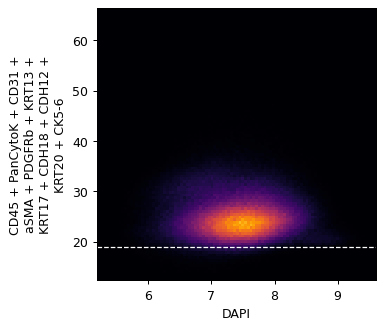

In [11]:
f1 = 'DAPI'
f2 = 'CD45,PanCytoK,CD31,aSMA,PDGFRb,KRT13,KRT17,CDH18,CDH12,KRT20,CK5-6'
blank = feature_histogram(adata,f1,f2,dapi_filter,vmax=0.1,v1cut=0,v2cut=19,rcut=np.log10(10+1), save='gate_figures/blank.svg') 
cell_sets['Blank'] = blank

12547


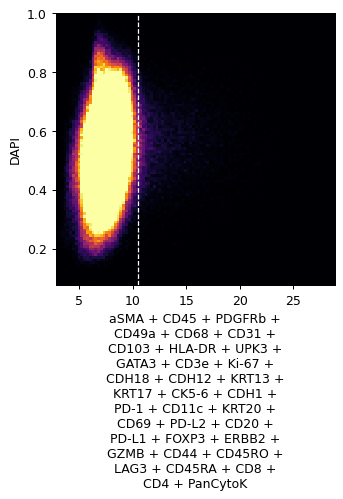

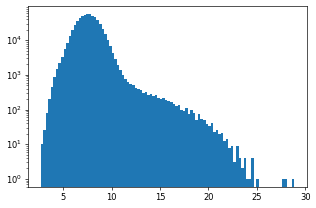

In [12]:
f1 = ','.join([c for c in adata.uns['channels'] if c !='DAPI'])
f2 = 'DAPI'
saturated, v1,v2 = feature_histogram(adata,f1,f2,dapi_filter,vmax=0.1,v1cut=10.5,v2cut=10,f1_fn=np.sum,
                              scaled=True, return_features=True, save='gate_figures/saturated.svg') 
cell_sets['Saturated'] = saturated
plt.figure()
_ = plt.hist(v1, bins=100, log=True)

In [13]:
sanity_filter = ~saturated & ~blank 
print(np.sum(sanity_filter))

585027


84217


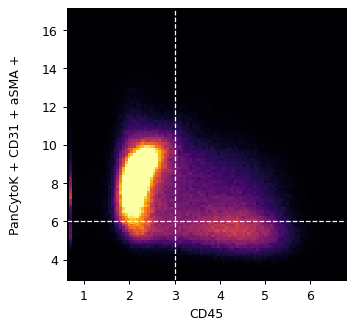

In [14]:
f1 = 'CD45'
f2 = 'PanCytoK,CD31,aSMA'
immune = feature_histogram(adata,f1,f2,sanity_filter,vmax=0.1,v1cut=3,v2cut=6,ft_suffix='membrane_mean', save='gate_figures/immune.svg') 
cell_sets['Immune'] = immune

41059


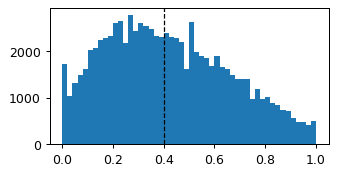

In [15]:
immune = filter_by_feature(adata, immune, 'CD45_ringpct', 0.4)
cell_sets['Immune'] = immune

In [16]:
# f1 = 'CD45'
# f2 = 'CDH12,CDH18'
# immune = feature_histogram(adata,f1,f2,immune,vmax=0.1,v1cut=3,v2cut=5.5,ft_suffix='nuclei_mean') 
# cell_sets['Immune'] = immune

In [17]:
adata.uns['channels']

array(['DAPI', 'aSMA', 'CD45', 'PDGFRb', 'CD49a', 'CD68', 'CD31', 'CD103',
       'HLA-DR', 'UPK3', 'GATA3', 'CD3e', 'Ki-67', 'CDH18', 'CDH12',
       'KRT13', 'KRT17', 'CK5-6', 'CDH1', 'PD-1', 'CD11c', 'KRT20',
       'CD69', 'PD-L2', 'CD20', 'PD-L1', 'FOXP3', 'ERBB2', 'GZMB', 'CD44',
       'CD45RO', 'LAG3', 'CD45RA', 'CD8', 'CD4', 'PanCytoK'], dtype=object)

206749


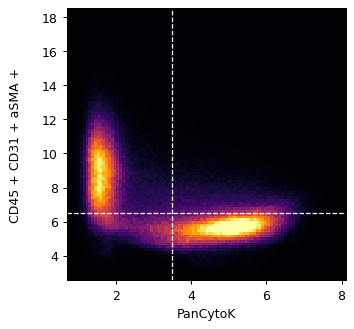

In [18]:
f1 = 'PanCytoK'
f2 = 'CD45,CD31,aSMA'

epithelial = feature_histogram(adata,f1,f2,sanity_filter & ~immune,vmax=0.1,v1cut=3.5,v2cut=6.5, save='gate_figures/epithelial.svg') 
cell_sets['Epithelial'] = epithelial

In [19]:
# f1 = 'PanCytoK'
# f2 = 'CD8,CD3e,CD4'

# epithelial = feature_histogram(adata,f1,f2,epithelial,vmax=0.5,v1cut=4,v2cut=6.75) 
# cell_sets['Epithelial'] = epithelial

30939


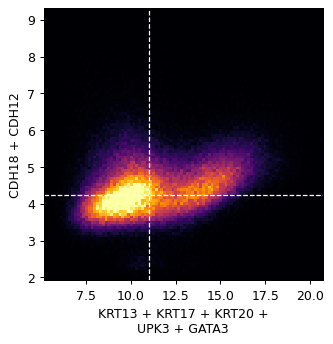

In [20]:
f1 = 'KRT13,KRT17,KRT20,UPK3,GATA3'
f2 = 'CDH18,CDH12'

epithelial_KRT = feature_histogram(adata,f1,f2,epithelial,vmax=0.1,v1cut=11,v2cut=4.25, save='gate_figures/epithelial_KRT.svg') 
cell_sets['Epithelial_KRT'] = epithelial_KRT

13200
15565
26201


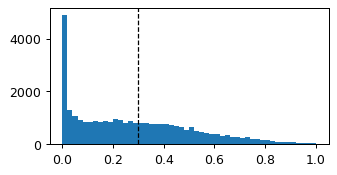

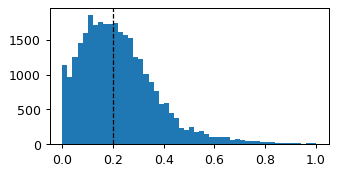

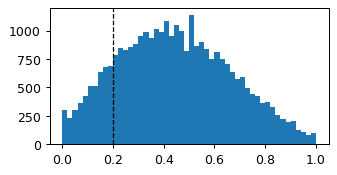

In [21]:
ep_KRT13 = filter_by_feature(adata, epithelial_KRT, 'KRT13_ringpct', 0.3)
ep_KRT17 = filter_by_feature(adata, epithelial_KRT, 'KRT17_ringpct', 0.2)
ep_PanCK = filter_by_feature(adata, epithelial_KRT, 'PanCytoK_ringpct', 0.2)
cell_sets['Epithelial_KRT'] = ep_KRT13 | ep_KRT17 | ep_PanCK

10415


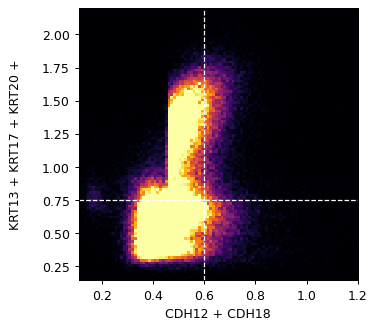

In [22]:
f1 = 'CDH12,CDH18'
f2 = 'KRT13,KRT17,KRT20'

epithelial_CDH = feature_histogram(adata,f1,f2,epithelial & ~cell_sets['Epithelial_KRT'],
                                   vmax=2,v1cut=0.6,v2cut=0.75,
                                  scaled=True, save='gate_figures/epithelial_CDH.svg') 
cell_sets['Epithelial_CDH'] = epithelial_CDH

6401


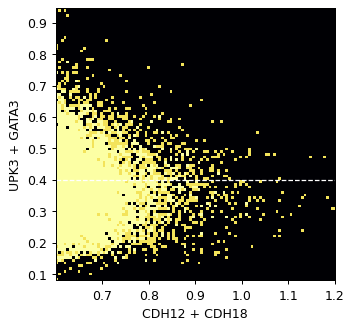

In [23]:
f1 = 'CDH12,CDH18'
f2 = 'UPK3,GATA3'

epithelial_CDH = feature_histogram(adata,f1,f2, epithelial_CDH, vmax=2,v1cut=0.55,v2cut=0.4,
                                  scaled=True) 
cell_sets['Epithelial_CDH'] = epithelial_CDH

4678


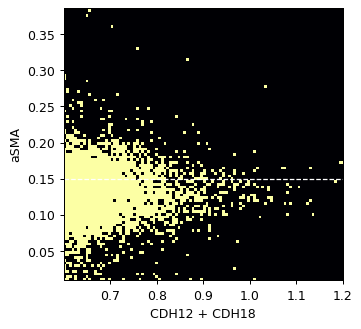

In [24]:
f1 = 'CDH12,CDH18'
f2 = 'aSMA'

epithelial_CDH = feature_histogram(adata,f1,f2, epithelial_CDH, vmax=2,v1cut=0.55,v2cut=0.15,
                                  scaled=True) 
cell_sets['Epithelial_CDH'] = epithelial_CDH

3619


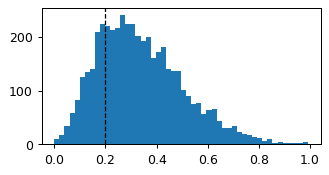

In [25]:
epithelial_CDH = filter_by_feature(adata, epithelial_CDH, 'CDH12_ringpct', 0.2)
cell_sets['Epithelial_CDH'] = epithelial_CDH

47745


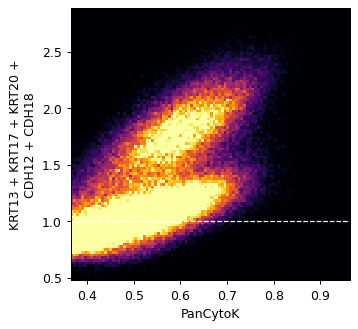

In [26]:
f1 = 'PanCytoK'
f2 = 'KRT13,KRT17,KRT20,CDH12,CDH18'

epithelial = feature_histogram(adata,f1,f2,epithelial,vmax=2.5,v1cut=0,v2cut=1,
                               scaled=True, save='gate_figures/epithelial_neg.svg') 
cell_sets['Epithelial'] = epithelial & ~epithelial_CDH & ~epithelial_KRT

25941


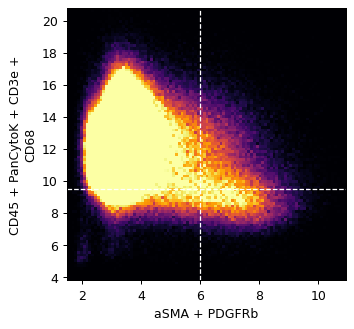

In [27]:
f1 = 'aSMA,PDGFRb'
f2 = 'CD45,PanCytoK,CD3e,CD68'

stromal = feature_histogram(adata,f1,f2,sanity_filter,vmax=0.01,v1cut=6,v2cut=9.5, save='gate_figures/stromal.svg') 

cell_sets['Stromal'] = stromal & ~epithelial

2771


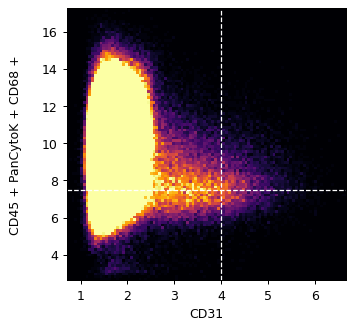

In [28]:
f1 = 'CD31'
f2 = 'CD45,PanCytoK,CD68'

endothelial = feature_histogram(adata,f1,f2,sanity_filter,vmax=0.01,v1cut=4,v2cut=7.5, save='gate_figures/endothelial.svg') 

cell_sets['Endothelial'] = endothelial

2544


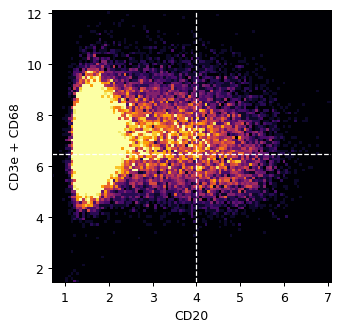

In [29]:
f1 = 'CD20'
f2 = 'CD3e,CD68'
bcell = feature_histogram(adata,f1,f2,immune,vmax=0.05,v1cut=4,v2cut=6.5,f1_fn=np.sum, save='gate_figures/bcell.svg') 

cell_sets['bcell'] = bcell

1232


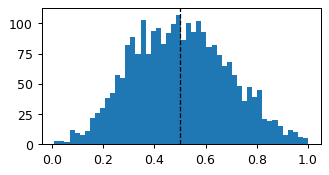

In [30]:
bcell = filter_by_feature(adata, bcell, 'CD20_ringpct', 0.5)

In [31]:
adata.uns['channels']

array(['DAPI', 'aSMA', 'CD45', 'PDGFRb', 'CD49a', 'CD68', 'CD31', 'CD103',
       'HLA-DR', 'UPK3', 'GATA3', 'CD3e', 'Ki-67', 'CDH18', 'CDH12',
       'KRT13', 'KRT17', 'CK5-6', 'CDH1', 'PD-1', 'CD11c', 'KRT20',
       'CD69', 'PD-L2', 'CD20', 'PD-L1', 'FOXP3', 'ERBB2', 'GZMB', 'CD44',
       'CD45RO', 'LAG3', 'CD45RA', 'CD8', 'CD4', 'PanCytoK'], dtype=object)

7954


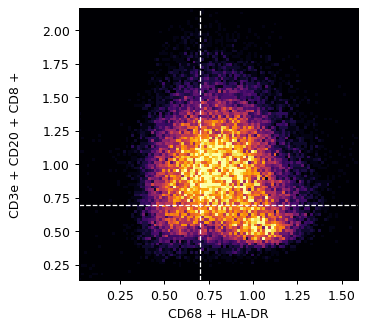

In [32]:
f1 = 'CD68,HLA-DR'
f2 = 'CD3e,CD20,CD8'

mac = feature_histogram(adata,f1,f2,immune,vmax=2,v1cut=0.7,v2cut=0.7,f1_fn=np.sum,
                        scaled=True,
                        ft_suffix='membrane_mean', save='gate_figures/mac.svg') 

cell_sets['mac'] = mac

4234


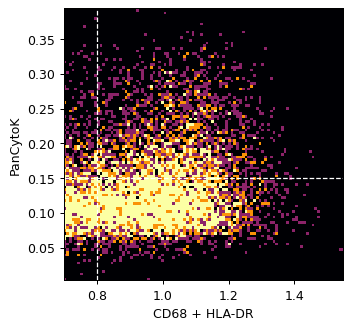

In [33]:
f1 = 'CD68,HLA-DR'
f2 = 'PanCytoK'

mac = feature_histogram(adata,f1,f2,mac,vmax=10,v1cut=0.8,v2cut=0.15,f1_fn=np.sum,
                        scaled=True,
                        ft_suffix='membrane_mean') 
cell_sets['mac'] = mac

2264


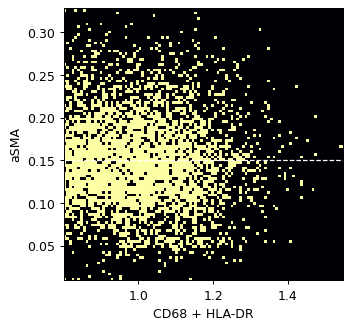

In [34]:
f1 = 'CD68,HLA-DR'
f2 = 'aSMA'

mac = feature_histogram(adata,f1,f2,mac,vmax=10,v1cut=0.3,v2cut=0.15,f1_fn=np.sum,
                        scaled=True,
                        ft_suffix='membrane_mean') 
cell_sets['mac'] = mac

10136


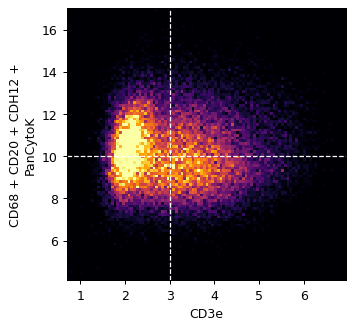

In [35]:
f1 = 'CD3e'
f2 = 'CD68,CD20,CDH12,PanCytoK'
tcell = feature_histogram(adata,f1,f2,immune,vmax=0.1,v1cut=3,v2cut=10,f1_fn=np.sum,
                          ft_suffix='nuclei_mean', save='gate_figures/tcell.svg') 
cell_sets['tcell'] = tcell

4372


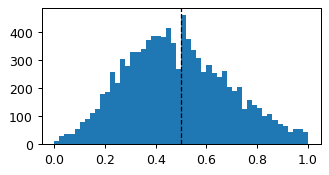

In [36]:
tcell = filter_by_feature(adata, tcell, 'CD3e_ringpct', 0.5)
cell_sets['tcell'] = tcell

1004


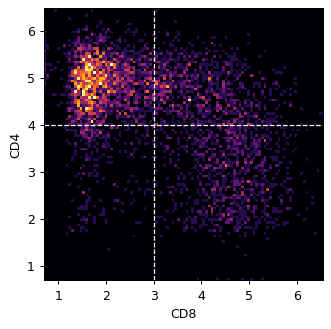

In [37]:
f1 = 'CD8'
f2 = 'CD4'
CD8T = feature_histogram(adata,f1,f2,tcell,vmax=0.5,v1cut=3,v2cut=4,f1_fn=np.sum, save='gate_figures/CD8T.svg') 

cell_sets['CD8T'] = CD8T

848


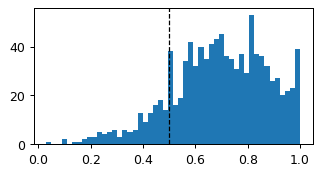

In [152]:
CD8T = filter_by_feature(adata, CD8T, 'CD8_ringpct', 0.5)
cell_sets['CD8T'] = CD8T

1580


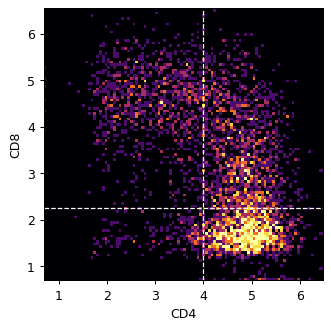

In [153]:
f1 = 'CD4'
f2 = 'CD8'
CD4T = feature_histogram(adata,f1,f2,tcell,vmax=0.3,v1cut=4,v2cut=2.25,f1_fn=np.sum, save='gate_figures/CD4T.svg') 
cell_sets['CD4T'] = CD4T

1088


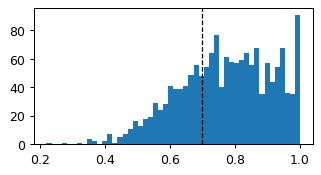

In [154]:
CD4T = filter_by_feature(adata, CD4T, 'CD4_ringpct', 0.7)
cell_sets['CD4T'] = CD4T

In [155]:
print(list(cell_sets.keys()))

['low_DAPI', 'Blank', 'Saturated', 'Immune', 'Epithelial', 'Epithelial_KRT', 'Epithelial_CDH', 'Stromal', 'Endothelial', 'bcell', 'mac', 'tcell', 'CD8T', 'CD4T']


In [156]:
cell_gates = np.zeros(adata.shape[0], dtype=object)
# Labels can be added in any order, except i think we want these to clobber:
#  - endothelial to clobber stromal
#  - Mac/Bcell/Tcell/CD4/CD8 clobbers "Immune"
#  - Plasma clobbers Stromal
#  - Blank clobbers everything
cell_gates[:] = 'Unassigned'
cell_gates[cell_sets['Immune']] = 'Immune'
cell_gates[cell_sets['Stromal']] = 'Stromal'
cell_gates[cell_sets['Endothelial']] = 'Endothelial'
# cell_gates[cell_sets['DC']] = 'DC'
cell_gates[cell_sets['mac']] = 'Mac'
cell_gates[cell_sets['bcell']] = 'Bcell'
cell_gates[cell_sets['tcell']] = 'Tcell'
cell_gates[cell_sets['CD8T']] = 'CD8T'
cell_gates[cell_sets['CD4T']] = 'CD4T'
# cell_gates[cell_sets['CD8T_exhausted']] = 'CD8T_exhausted'
cell_gates[cell_sets['Epithelial']] = 'Epithelial'
cell_gates[cell_sets['Epithelial_KRT']] = 'Epithelial_KRT'
# cell_gates[cell_sets['Epithelial_CK6']] = 'Epithelial_CK6'
cell_gates[cell_sets['Epithelial_CDH']] = 'Epithelial_CDH'
cell_gates[cell_sets['Blank']] = 'Blank'
cell_gates[cell_sets['Saturated']] = 'Saturated'
cell_gates[cell_sets['low_DAPI']] = 'low_DAPI'

adata.obs['cell_gates'] = pd.Categorical(cell_gates)
adata.obs['cell_gates'].value_counts()

Unassigned        436142
Epithelial         46881
Immune             31882
Epithelial_KRT     27939
Stromal            24141
Blank              17597
Saturated          12547
Epithelial_CDH      3617
Endothelial         2765
Bcell               2538
low_DAPI            2501
Tcell               2436
Mac                 2249
CD4T                1088
CD8T                 848
Name: cell_gates, dtype: int64

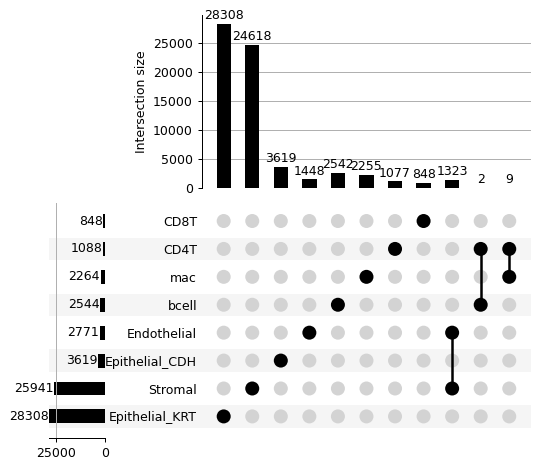

In [157]:
from upsetplot import plot as upsetplotter
from upsetplot import from_memberships
from upsetplot import UpSet

rcParams['figure.dpi'] = 90
vals = []
names = []
has_class = np.zeros(adata.shape[0], dtype=np.uint8)
for n, s in cell_sets.items():
    if n in ['Immune', 'Blank', 'dc', 'low_DAPI', 'tcell', 'Epithelial', 'Saturated']:
        continue
    vals.append(s)
    names.append(n)
    has_class[s] += 1
        
for i in range(len(vals)):
    v = vals[i]
    vals[i] = v[has_class>0]

i = pd.MultiIndex.from_arrays(vals, names=names)
df = pd.DataFrame(index=i)

UpSet(df, show_counts=True)


In [158]:
marker_channels = ['aSMA', 'CD45', 'PDGFRb', 'CD68', 'CD31', 
                   'HLA-DR', 'UPK3', 'GATA3', 'CD3e', 'CDH18', 'CDH12',
                   'KRT13', 'KRT17', 'CK5-6','KRT20',
                   'CD20', 'CD8', 'CD4', 'PanCytoK']

features = [f'{c}_membrane_mean' for c in marker_channels]
features += [f'{c}_nuclei_mean' for c in marker_channels]
# features = [f'{c}_membrane_mean' for c in adata.uns['channels']]
# features += [f'{c}_nuclei_mean' for c in adata.uns['channels']]
# features += [f'{c}_nuclei_std' for c in adata.uns['channels']]
# features += [f'{c}_membrane_std' for c in marker_channels]
# features += [c for c in adata.var_names if 'membrane_q' in c]
# for i in range(1,9):
#     features += [f'{c}_membrane_b{i}' for c in adata.uns['channels']]

print(len(features))

38


In [159]:
pct_features = np.array(adata.obs.loc[:, [c for c in adata.obs.columns if 'pct' in c]].values)
pct_features.shape

(615171, 12)

In [160]:
from sklearn.preprocessing import RobustScaler

In [161]:
# core_channels = ['CD68', 'CD3e', 'PanCytoK', 'aSMA', 'CD31', 'PDGFRb', 
#                  'CD8', 'CD4', 'CD20', 'CD45', 'CD138']
# core_features = [f'{v}_membrane_mean' for v in core_channels]
# features = [x for x in adata.var_names if 'membrane' in x]

do_not_use_labels = ['Unassigned', 'low_DAPI', 
#                      'Blank', 
                     'Epithelial_CK6',
#                      'Saturated'
                    ]
training = ~adata.obs.cell_gates.isin(do_not_use_labels)

X_train = adata[training, features].X.toarray()
# X_train = np.log10(1+X_train)
X_train = np.concatenate([np.log10(1+X_train), pct_features[training]], axis=1)
Y_train = np.array(adata[training].obs['cell_gates'])
print(X_train.shape, Y_train.shape)

# Sample similar numbers of each group
np.random.seed(999)
target = 2500
X_train_choice = []
Y_train_choice = []
X_heldout = []
Y_heldout = []
for c in np.unique(Y_train):
    z = Y_train==c
    print(c,np.sum(z))
    xz = X_train[z,:]
#     choice = np.random.choice(np.sum(z), min(np.sum(z), target), replace=False)
    choice = np.random.choice(np.sum(z), target, replace=False if np.sum(z)>target else True)
    if np.sum(z)>target:
        mask = np.zeros(z.sum(),dtype=np.bool)
        mask[choice] = 1
        xz_ = xz[~mask,:]
        xz = xz[mask,:]
        X_train_choice.append(xz)
        X_heldout.append(xz_)
        Y_heldout += [c]*np.sum(~mask)
    else:
        xz = xz[choice,:]
        X_train_choice.append(xz)
#     Y_train_choice += [c]*min(np.sum(z), target)
    Y_train_choice += [c]*target

X_train = np.concatenate(X_train_choice, axis=0)
Y_train = np.array(Y_train_choice)

X_heldout = np.concatenate(X_heldout, axis=0)
Y_heldout = np.array(Y_heldout)

X_train = np.log10(1+X_train)
# scaler = MinMaxScaler()
scaler = RobustScaler(with_centering=True, unit_variance=False)
X_heldout = np.log10(1+X_heldout)
X_heldout = scaler.fit_transform(X_heldout)
X_train = scaler.transform(X_train)

print(X_train.shape, Y_train.shape)
print(X_heldout.shape, Y_heldout.shape)

(176528, 50) (176528,)
Bcell 2538
Blank 17597
CD4T 1088
CD8T 848
Endothelial 2765
Epithelial 46881
Epithelial_CDH 3617
Epithelial_KRT 27939
Immune 31882
Mac 2249
Saturated 12547
Stromal 24141
Tcell 2436
(32500, 50) (32500,)
(147407, 50) (147407,)


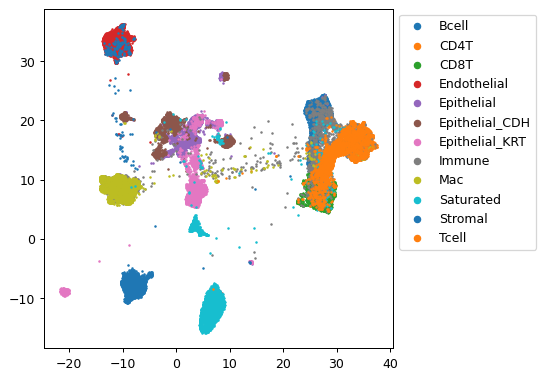

In [162]:
nbr = 25
nn_model = cuml.neighbors.NearestNeighbors(n_neighbors=nbr, 
                                           metric='euclidean', 
                                           output_type='numpy')
X_umap = X_train[Y_train!='Blank']
Y_umap = Y_train[Y_train!='Blank']

nn_model.fit(X_umap)
adjacency = nn_model.kneighbors_graph(X_umap)

umap = cuml.UMAP(n_neighbors=nbr, learning_rate=1, min_dist=0.5, spread=2, 
                 local_connectivity=1, repulsion_strength=1)
umap.fit(X_umap, knn_graph=adjacency)
emb = umap.transform(X_umap, knn_graph=adjacency)

plt.figure(figsize=(5,5),dpi=90)
for g in np.unique(Y_umap):
    ix = Y_umap==g
    plt.scatter(emb[ix,0], emb[ix,1],s=1,label=g, rasterized=True)
plt.legend(bbox_to_anchor=(1,1), markerscale=5)
plt.savefig('gate_figures/celltype_training_umap.svg', bbox_inches='tight')

In [163]:
# pred_idx = adata.obs.cell_gates == 'Unassigned'
pred_idx = ~training
X_pred = adata[pred_idx, features].X.toarray()
# X_pred = np.log10(1+X_pred)
X_pred = np.concatenate([np.log10(1+X_pred), pct_features[pred_idx]], axis=1)
X_pred = scaler.fit_transform(X_pred)
Y_levels, Y_train_numeric = np.unique(Y_train, return_inverse=True)
_, Y_heldout_numeric = np.unique(Y_heldout, return_inverse=True)
print(X_pred.shape)

(438643, 50)


In [164]:
from sklearn.ensemble import RandomForestClassifier
from cuml.neighbors import KNeighborsClassifier
from cuml.ensemble import RandomForestClassifier as RandomForestClassifier_GPU
from cuml.svm import SVC
# cuml.neighbors.KNeighborsClassifier(weights='uniform', *, handle=None, 
#                                     verbose=False, output_type=None, **kwargs)

In [165]:
# cls = RandomForestClassifier_GPU(max_features=0.2, n_estimators=100,
#                                  use_experimental_backend=True,
#                                  n_bins=16, max_batch_size=512,
#                                  max_depth=32
#                                 )

cls = KNeighborsClassifier(n_neighbors=200, weights='uniform',  
                           verbose=False, output_type='numpy')

# cls = SVC(class_weight='balanced')

# cls = RandomForestClassifier(max_features=1.0, n_estimators=150,
#                              max_depth=36 , n_jobs=-1
#                             )

cls.fit(X_train, Y_train_numeric)
Y_pred = cls.predict(X_pred)
Y_pred_prob = cls.predict_proba(X_pred)

Y_heldout_pred = cls.predict(X_heldout)

Y_pred_mapped = np.zeros(Y_pred.shape[0], dtype='object')
Y_heldout_pred_mapped = np.zeros(Y_heldout_pred.shape[0], dtype='object')
for u in np.unique(Y_pred):
    u = int(u)
    print(Y_levels[u], np.sum(Y_pred==u), np.sum(Y_heldout_pred==u), sep='\t')
    Y_pred_mapped[Y_pred==u] = Y_levels[u]
    Y_heldout_pred_mapped[Y_heldout_pred==u] = Y_levels[u]
    

Bcell	14889	4151
Blank	36305	16502
CD4T	12016	3859
CD8T	11449	3311
Endothelial	14676	1944
Epithelial	122763	42461
Epithelial_CDH	34568	4004
Epithelial_KRT	79313	22712
Immune	21910	6974
Mac	36612	9151
Saturated	6566	9249
Stromal	37969	20028
Tcell	9607	3061


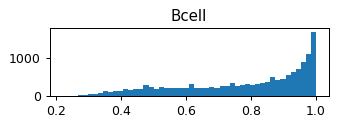

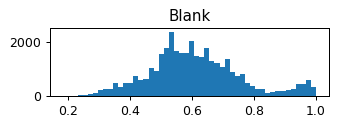

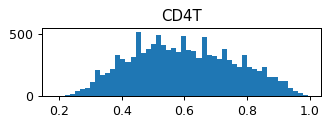

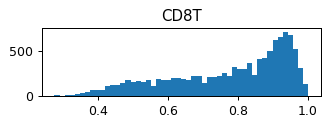

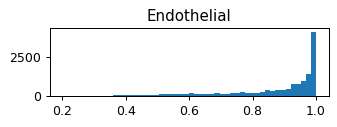

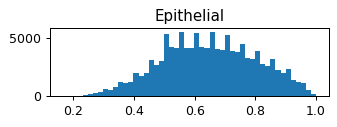

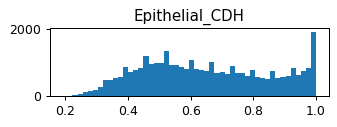

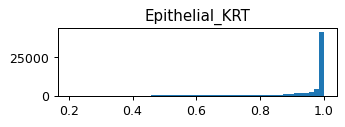

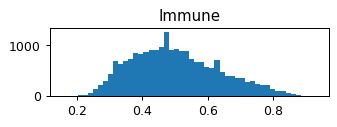

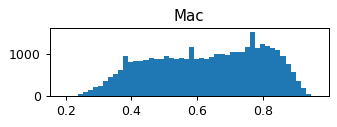

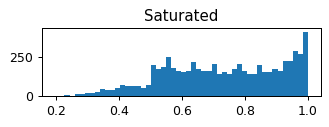

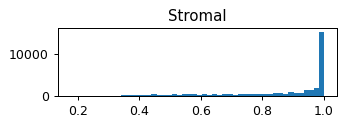

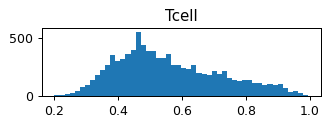

In [166]:
rcParams['figure.dpi'] = 90
ymax = np.max(Y_pred_prob, axis=1)
for u in np.unique(Y_pred):
    plt.figure(figsize=(4,1))
    _ = plt.hist(ymax[Y_pred==u], bins=50)
    plt.title(Y_levels[int(u)])

In [167]:
combined_labels = np.array(adata.obs.cell_gates)
combined_labels[pred_idx] = Y_pred_mapped
# Remap Tcell --> Immune
combined_labels[combined_labels=='Tcell'] = 'Immune'
adata.obs['celltype_gating'] = pd.Categorical(combined_labels)
adata.obs['celltype_gating'].value_counts()

Epithelial        169644
Epithelial_KRT    107252
Immune             65835
Stromal            62110
Blank              53902
Mac                38861
Epithelial_CDH     38185
Saturated          19113
Endothelial        17441
Bcell              17427
CD4T               13104
CD8T               12297
Name: celltype_gating, dtype: int64

In [168]:
summary_features = [f'{c}_membrane_mean' for c in adata.uns['channels']]

/home/ingn/devel/scrna/scrna/plotting_utils.py:587: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(u_groups, fontsize=6, rotation=90)


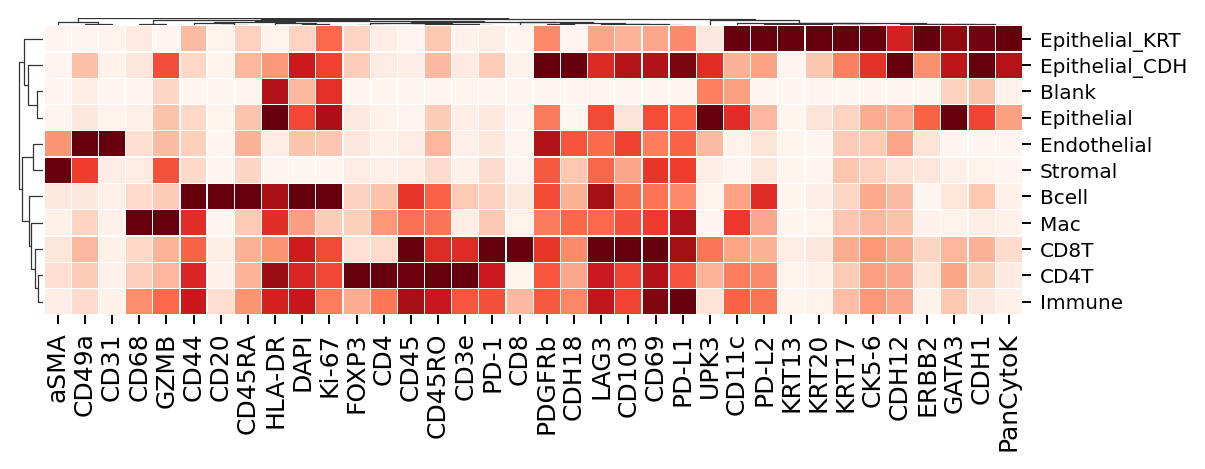

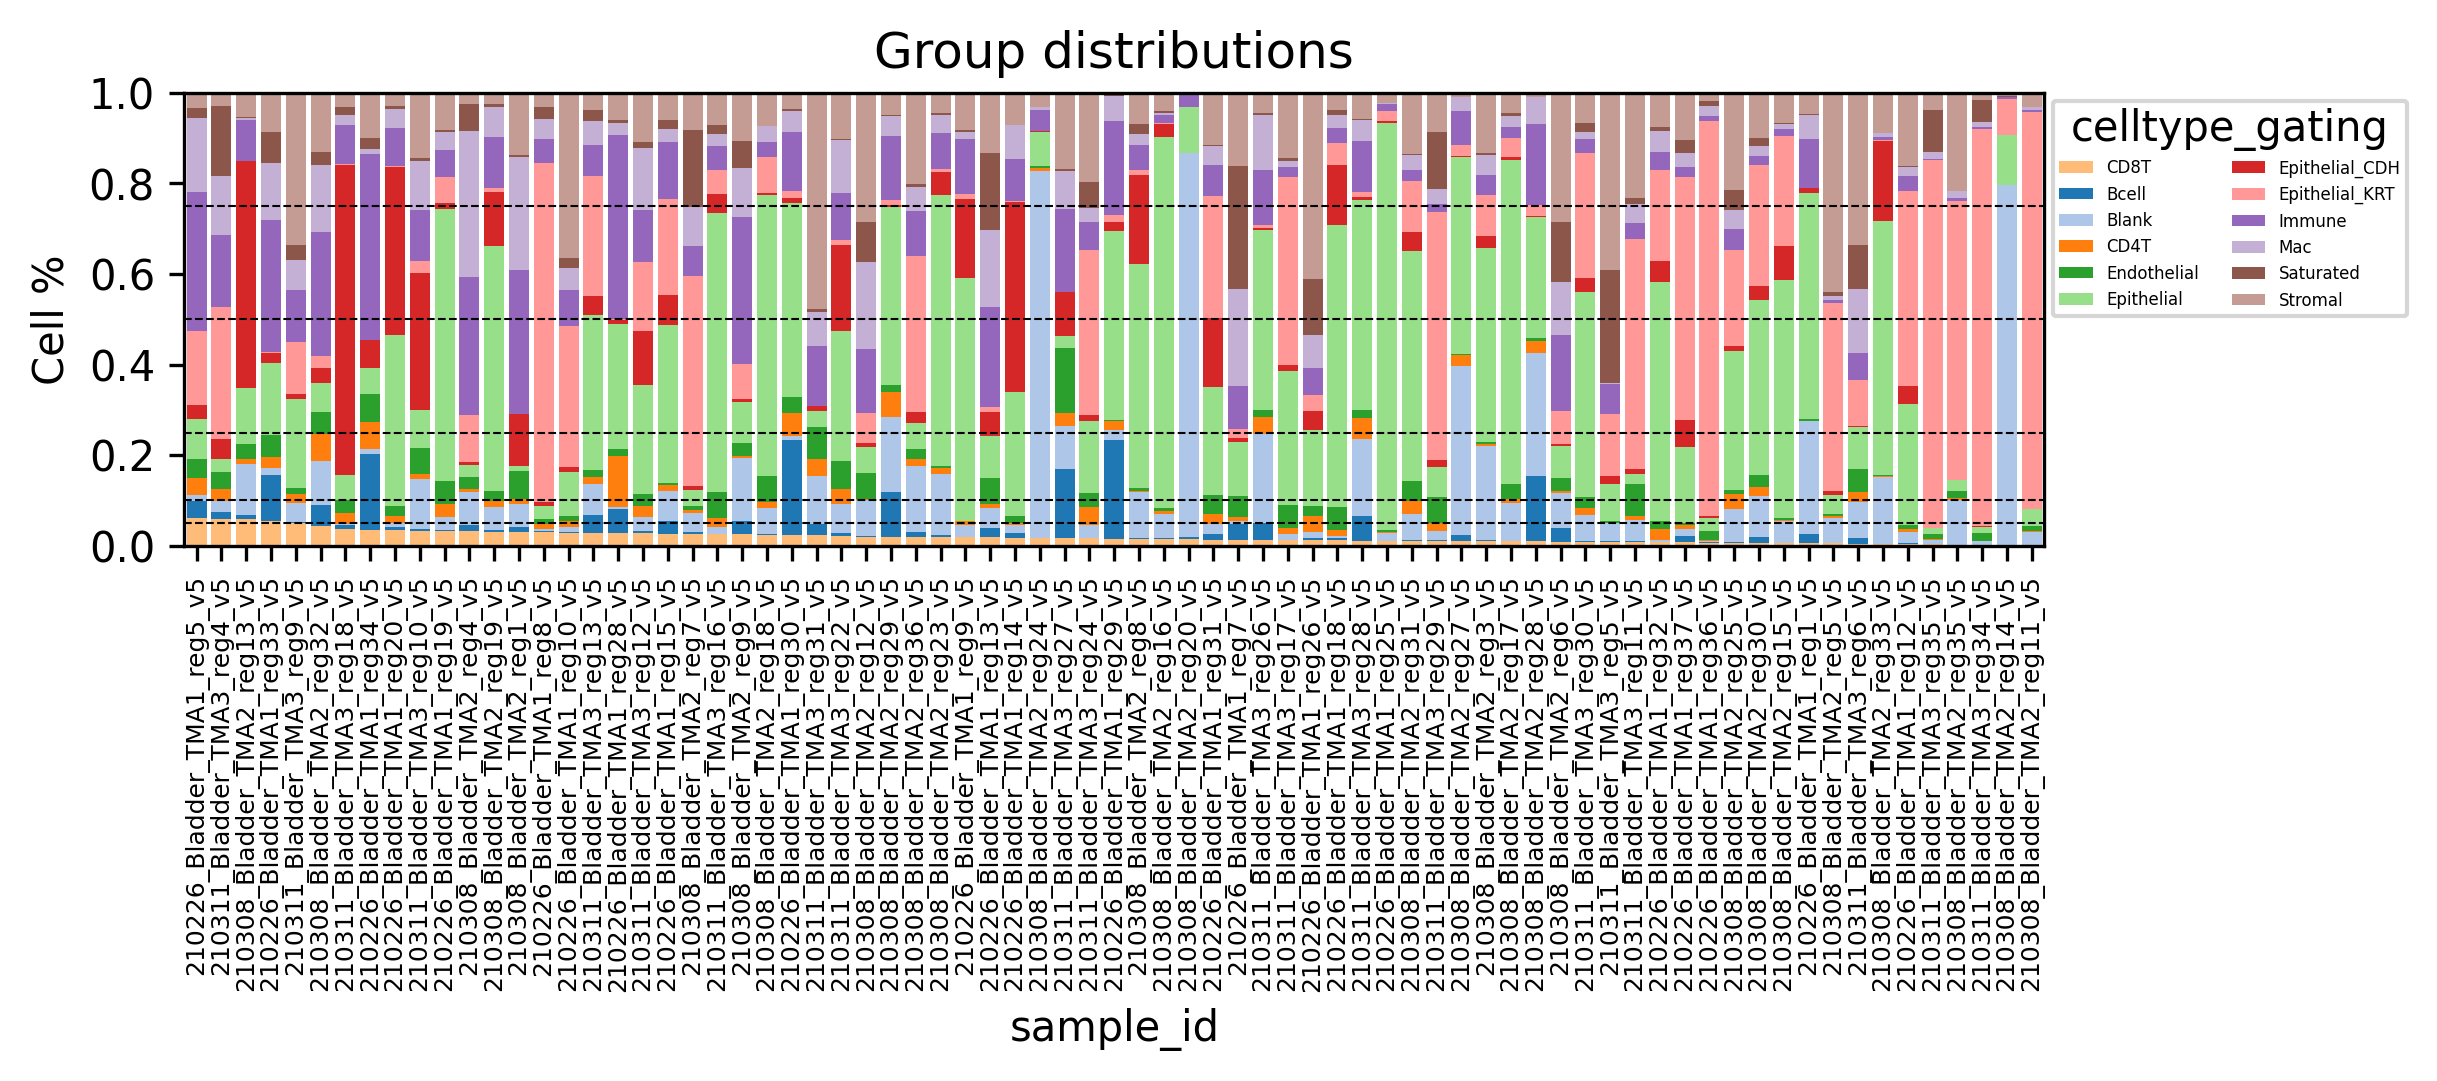

In [169]:
scrna.plot_heatmap(adata, 
                   summary_features, groupby='celltype_gating',
                   rm_groups=['Saturated'],
                   standard_scale=1, cmap='Reds', center_cmap=None, 
#                    z_score=1, cmap='RdBu_r', center_cmap=0, 
                   transpose=False,
                   replace_xticklabels={f:f.split('_')[0] for f in summary_features},
                   figsize=(7,4))

scrna.plot_group_percents(adata, 'celltype_gating', 'sample_id', sort_by='CD8T')

In [170]:
adata.obs.celltype_gating.value_counts()

Epithelial        169644
Epithelial_KRT    107252
Immune             65835
Stromal            62110
Blank              53902
Mac                38861
Epithelial_CDH     38185
Saturated          19113
Endothelial        17441
Bcell              17427
CD4T               13104
CD8T               12297
Name: celltype_gating, dtype: int64

In [171]:
adata

AnnData object with n_obs × n_vars = 615171 × 1440
    obs: 'CD45_ringpct', 'CD20_ringpct', 'CD3e_ringpct', 'CD45RO_ringpct', 'CD45RA_ringpct', 'CD8_ringpct', 'CD4_ringpct', 'CDH12_ringpct', 'KRT13_ringpct', 'KRT17_ringpct', 'PanCytoK_ringpct', 'ERBB2_ringpct', 'sample_id', 'sample_id_printing', 'snSeq_sample', 'patient', 'biopsy', 'Filtered_DAPI', 'cell_gates', 'celltype_gating'
    uns: 'channels', 'patient_colors', 'sample_id_printing_colors', 'sample_layout', 'snSeq_sample_colors'
    obsm: 'coordinates', 'coordinates_shift'

In [172]:
adata.uns['channels']

array(['DAPI', 'aSMA', 'CD45', 'PDGFRb', 'CD49a', 'CD68', 'CD31', 'CD103',
       'HLA-DR', 'UPK3', 'GATA3', 'CD3e', 'Ki-67', 'CDH18', 'CDH12',
       'KRT13', 'KRT17', 'CK5-6', 'CDH1', 'PD-1', 'CD11c', 'KRT20',
       'CD69', 'PD-L2', 'CD20', 'PD-L1', 'FOXP3', 'ERBB2', 'GZMB', 'CD44',
       'CD45RO', 'LAG3', 'CD45RA', 'CD8', 'CD4', 'PanCytoK'], dtype=object)

In [173]:
subtype_sets = {}

674


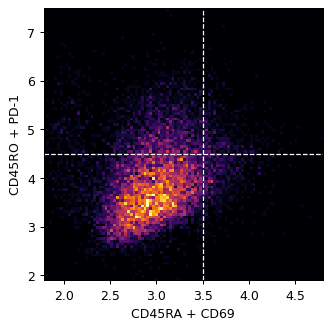

In [174]:
f1 = 'CD45RA,CD69'
f2 = 'CD45RO,PD-1'
CD8T_activated = feature_histogram(adata,f1,f2,adata.obs.celltype_gating=='CD8T',
                      vmax=1,v1cut=3.5,v2cut=4.5,f1_fn=np.sum, save='gate_figures/CD8T_activated.svg') 
subtype_sets['CD8T_activated'] = CD8T_activated

437.0


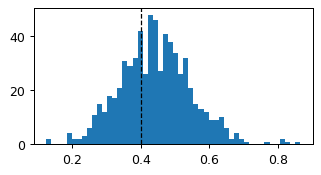

In [175]:
CD8T_activated = filter_by_feature(adata, CD8T_activated, 'CD45RA_ringpct', 0.4)
cell_sets['CD8T_activated'] = CD8T_activated

310


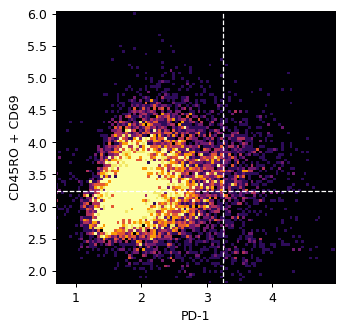

In [176]:
f1 = 'PD-1'
f2 = 'CD45RO,CD69'
CD8T_exhausted = feature_histogram(adata,f1,f2,(adata.obs.celltype_gating=='CD8T')&~CD8T_activated.astype(np.bool),
                      vmax=0.3,v1cut=3.25,v2cut=3.25,f1_fn=np.sum, save='gate_figures/CD8T_exhausted.svg') 
subtype_sets['CD8T_exhausted'] = CD8T_exhausted

297


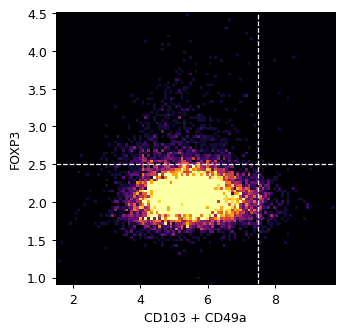

In [177]:
f1 = 'CD103,CD49a'
f2 = 'FOXP3'
CD8T_Trm = feature_histogram(adata,f1,f2,adata.obs.celltype_gating=='CD8T',
                      vmax=0.3,v1cut=7.5,v2cut=2.5,f1_fn=np.sum, save='gate_figures/CD8T_Trm.svg') 
subtype_sets['CD8T_Trm'] = CD8T_Trm

350


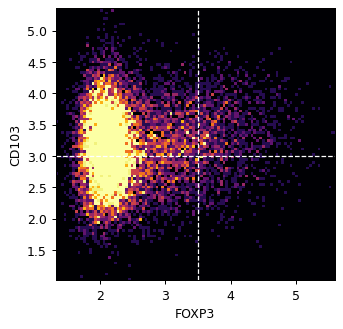

In [178]:
f1 = 'FOXP3'
f2 = 'CD103'
CD4T_Treg = feature_histogram(adata,f1,f2,adata.obs.celltype_gating=='CD4T',
                      vmax=0.3,v1cut=3.5,v2cut=3,f1_fn=np.sum, save='gate_figures/CD4T_Treg.svg') 
subtype_sets['CD4T_Treg'] = CD4T_Treg

In [179]:
subtype_gates = np.zeros(adata.shape[0], dtype=object)
subtype_gates[:] = 'Unassigned'
subtype_gates[adata.obs.celltype_gating=='CD8T'] = 'CD8T'
subtype_gates[subtype_sets['CD8T_activated']] = 'CD8T_activated'
subtype_gates[subtype_sets['CD8T_exhausted']] = 'CD8T_exhausted'
subtype_gates[subtype_sets['CD8T_Trm']] = 'CD8T_Trm'
subtype_gates[adata.obs.celltype_gating=='CD4T'] = 'CD4T'
subtype_gates[subtype_sets['CD4T_Treg']] = 'CD4T_Treg'

adata.obs['subtype_gates'] = pd.Categorical(subtype_gates)
adata.obs['subtype_gates'].value_counts()

Unassigned        589770
CD4T               12754
CD8T               11040
CD8T_activated       662
CD4T_Treg            350
CD8T_exhausted       298
CD8T_Trm             297
Name: subtype_gates, dtype: int64

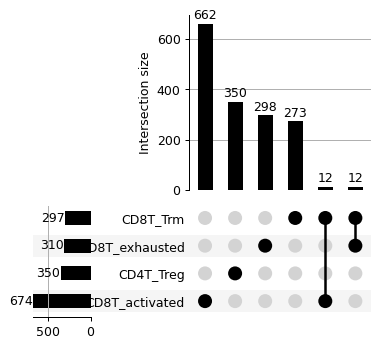

In [180]:
rcParams['figure.dpi'] = 90
vals = []
names = []
has_class = np.zeros(adata.shape[0], dtype=np.uint8)
for n, s in subtype_sets.items():
    vals.append(s)
    names.append(n)
    has_class[s] += 1
        
for i in range(len(vals)):
    v = vals[i]
    vals[i] = v[has_class>0]

i = pd.MultiIndex.from_arrays(vals, names=names)
df = pd.DataFrame(index=i)

UpSet(df, show_counts=True)


In [181]:
marker_channels = ['CD49a', 'CD103',
 'CD3e',  'PD-1',  'CD69', 'FOXP3', 
 'CD45RO', 'CD45RA', 'CD8', 'CD4']

subtype_features = [f'{c}_membrane_mean' for c in marker_channels]
# subtype_features += [f'{c}_nuclei_mean' for c in marker_channels]
# features = [f'{c}_membrane_mean' for c in adata.uns['channels']]
# features += [f'{c}_nuclei_mean' for c in adata.uns['channels']]
# features += [f'{c}_nuclei_std' for c in adata.uns['channels']]
# subtype_features += [f'{c}_membrane_std' for c in marker_channels]

print(len(subtype_features))

10


In [182]:
training = ~adata.obs.subtype_gates.isin(['Unassigned'])

X_train = adata[training, features].X.toarray()
X_train = np.log10(1+X_train)
# X_train = np.concatenate([np.log10(1+X_train), pct_features[training]], axis=1)
Y_train = np.array(adata[training].obs['subtype_gates'])
print(X_train.shape, Y_train.shape)

# Sample similar numbers of each group
np.random.seed(999)
target = 500
X_train_choice = []
Y_train_choice = []
X_heldout = []
Y_heldout = []
for c in np.unique(Y_train):
    z = Y_train==c
    print(c,np.sum(z))
    xz = X_train[z,:]
    choice = np.random.choice(np.sum(z), min(np.sum(z), target), replace=False)
    mask = np.zeros(z.sum(),dtype=np.bool)
    mask[choice] = 1
    xz_ = xz[~mask,:]
    xz = xz[mask,:]
    X_train_choice.append(xz)
    Y_train_choice += [c]*min(np.sum(z), target)
    X_heldout.append(xz_)
    Y_heldout += [c]*np.sum(~mask)

X_train = np.concatenate(X_train_choice, axis=0)
Y_train = np.array(Y_train_choice)

X_heldout = np.concatenate(X_heldout, axis=0)
Y_heldout = np.array(Y_heldout)

# X_train = np.log10(1+X_train)
# scaler = MinMaxScaler()
scaler = RobustScaler(with_centering=True, unit_variance=False)
# X_heldout = np.log10(1+X_heldout)
X_heldout = scaler.fit_transform(X_heldout)
X_train = scaler.transform(X_train)

print(X_train.shape, Y_train.shape)
print(X_heldout.shape, Y_heldout.shape)

(25401, 38) (25401,)
CD4T 12754
CD4T_Treg 350
CD8T 11040
CD8T_Trm 297
CD8T_activated 662
CD8T_exhausted 298
(2445, 38) (2445,)
(22956, 38) (22956,)


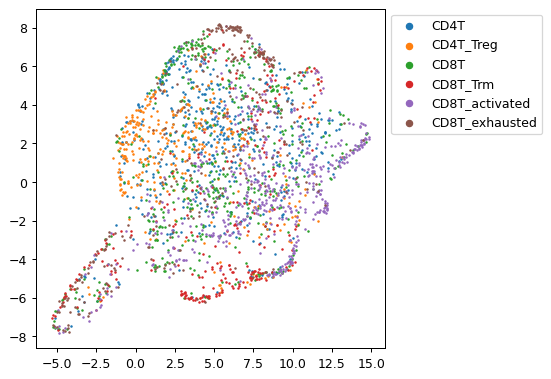

In [183]:
nbr = 25
nn_model = cuml.neighbors.NearestNeighbors(n_neighbors=nbr, 
                                           metric='euclidean', 
                                           output_type='numpy')
X_umap = X_train[Y_train!='Blank']
Y_umap = Y_train[Y_train!='Blank']

nn_model.fit(X_umap)
adjacency = nn_model.kneighbors_graph(X_umap)

umap = cuml.UMAP(n_neighbors=nbr, learning_rate=1, min_dist=0.5, spread=2, 
                 local_connectivity=1, repulsion_strength=1)
umap.fit(X_umap, knn_graph=adjacency)
emb = umap.transform(X_umap, knn_graph=adjacency)

plt.figure(figsize=(5,5),dpi=90)
for g in np.unique(Y_umap):
    ix = Y_umap==g
    plt.scatter(emb[ix,0], emb[ix,1],s=1,label=g)
plt.legend(bbox_to_anchor=(1,1), markerscale=5)

In [184]:
pred_idx = adata.obs.celltype_gating.isin(['CD8T', 'CD4T'])
X_pred = adata[pred_idx, features].X.toarray()
X_pred = np.log10(1+X_pred)
# X_pred = np.concatenate([np.log10(1+X_pred), pct_features[pred_idx]], axis=1)
X_pred = scaler.fit_transform(X_pred)
Y_levels, Y_train_numeric = np.unique(Y_train, return_inverse=True)
_, Y_heldout_numeric = np.unique(Y_heldout, return_inverse=True)
print(X_pred.shape)

(25401, 38)


In [185]:
# cls = cuml.ensemble.RandomForestClassifier(max_features=1.0, n_estimators=10,
#                                            use_experimental_backend=True,
#                                            n_bins=16, max_batch_size=512,
#                                            max_depth=32
#                                           )

cls = cuml.neighbors.KNeighborsClassifier(n_neighbors=100, weights='uniform', 
                                          verbose=False, output_type='numpy')

# cls = RandomForestClassifier(max_features=1.0, n_estimators=150,
#                              max_depth=36 , n_jobs=-1
#                             )

cls.fit(X_train, Y_train_numeric)
Y_pred = cls.predict(X_pred)
Y_pred_prob = cls.predict_proba(X_pred)

Y_heldout_pred = cls.predict(X_heldout)

Y_pred_mapped = np.zeros(Y_pred.shape[0], dtype='object')
Y_heldout_pred_mapped = np.zeros(Y_heldout_pred.shape[0], dtype='object')
for u in np.unique(Y_pred):
    u = int(u)
    print(Y_levels[u], np.sum(Y_pred==u), np.sum(Y_heldout_pred==u), sep='\t')
    Y_pred_mapped[Y_pred==u] = Y_levels[u]
    Y_heldout_pred_mapped[Y_heldout_pred==u] = Y_levels[u]
    

CD4T	11274	10303
CD4T_Treg	1848	1584
CD8T	5609	5235
CD8T_Trm	846	715
CD8T_activated	4420	3936
CD8T_exhausted	1404	1183


In [186]:
Y_pred_mapped.shape

(25401,)

In [187]:
combined_labels = np.array(adata.obs.celltype_gating)
combined_labels[training] = subtype_gates[training]
combined_labels[pred_idx] = Y_pred_mapped
adata.obs['subtype_gating'] = pd.Categorical(combined_labels)
adata.obs['subtype_gating'].value_counts()

Epithelial        169644
Epithelial_KRT    107252
Immune             65835
Stromal            62110
Blank              53902
Mac                38861
Epithelial_CDH     38185
Saturated          19113
Endothelial        17441
Bcell              17427
CD4T               11274
CD8T                5609
CD8T_activated      4420
CD4T_Treg           1848
CD8T_exhausted      1404
CD8T_Trm             846
Name: subtype_gating, dtype: int64

/home/ingn/devel/scrna/scrna/plotting_utils.py:587: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(u_groups, fontsize=6, rotation=90)


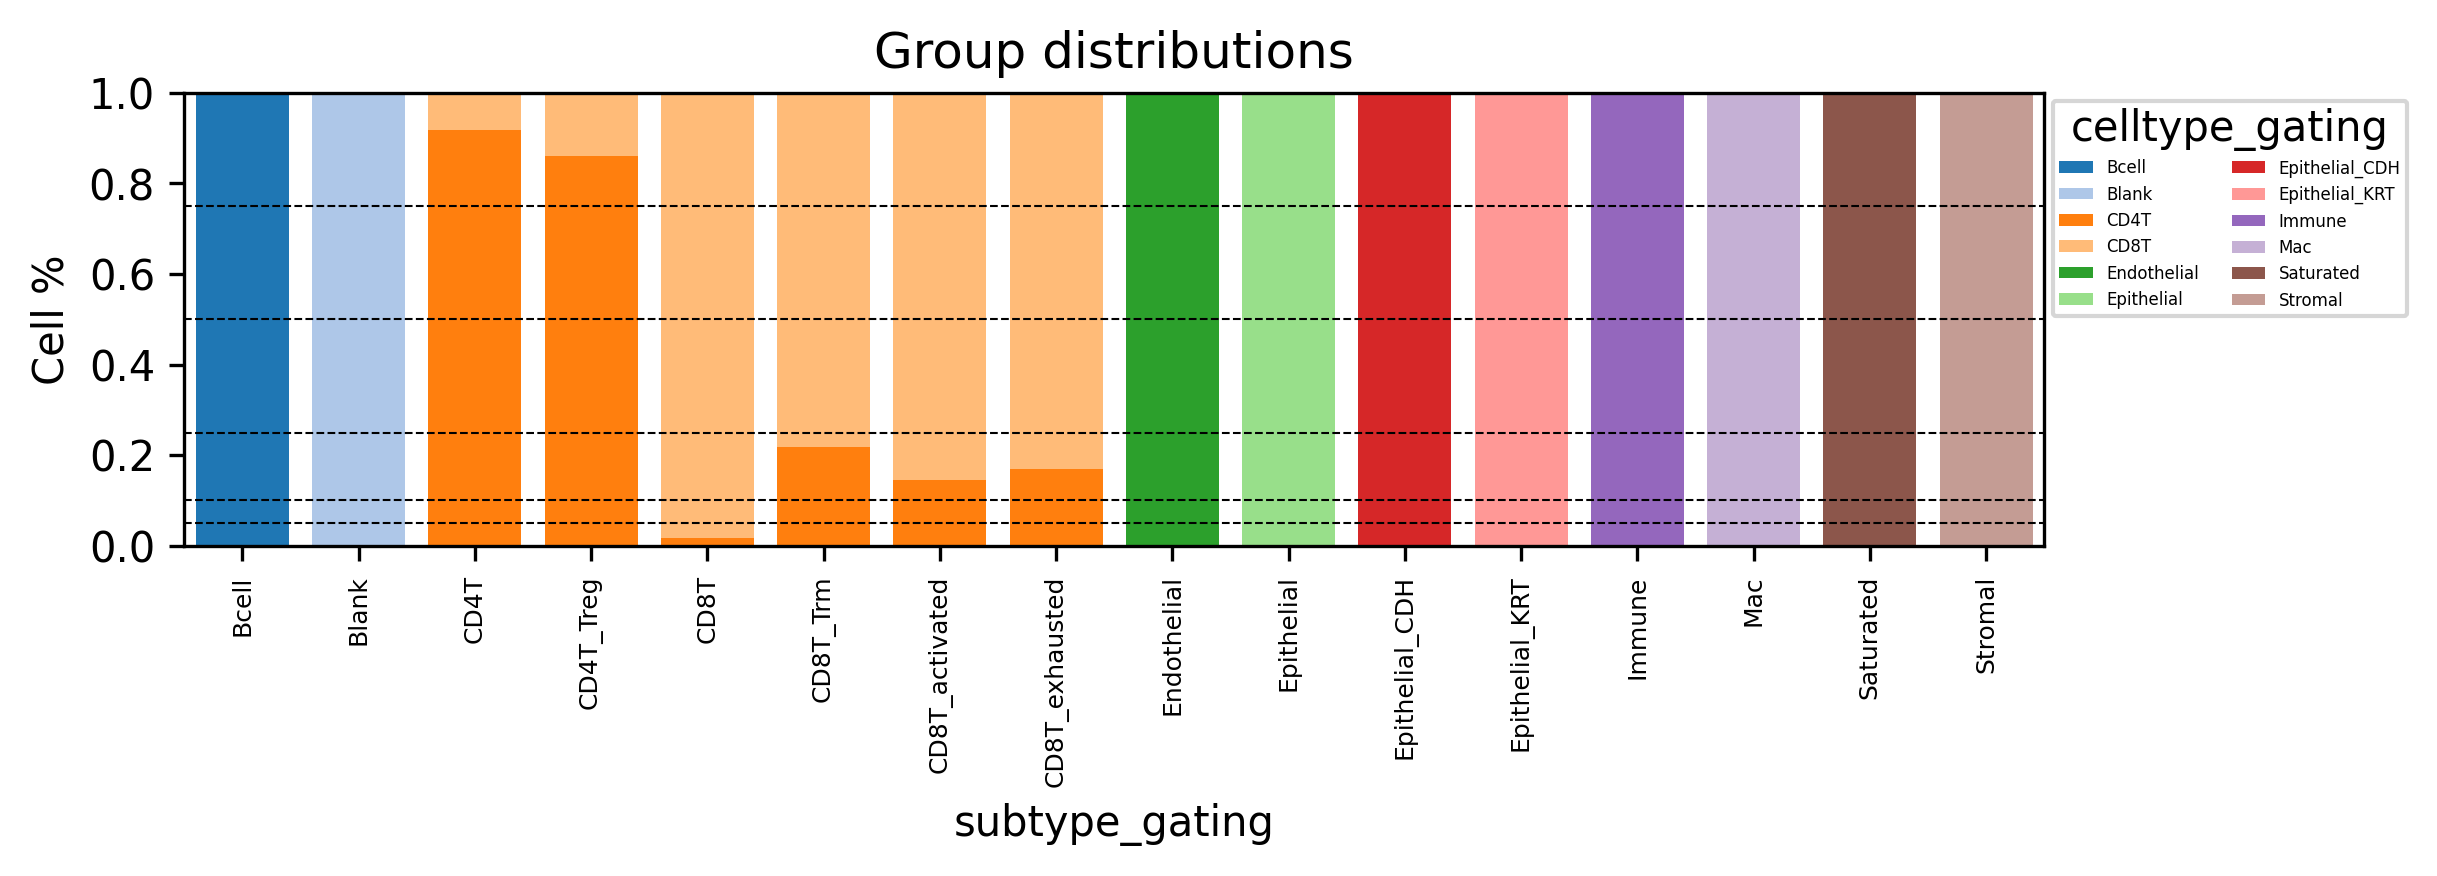

In [188]:
scrna.plot_group_percents(adata, 'celltype_gating',  'subtype_gating')

/home/ingn/devel/scrna/scrna/plotting_utils.py:587: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(u_groups, fontsize=6, rotation=90)


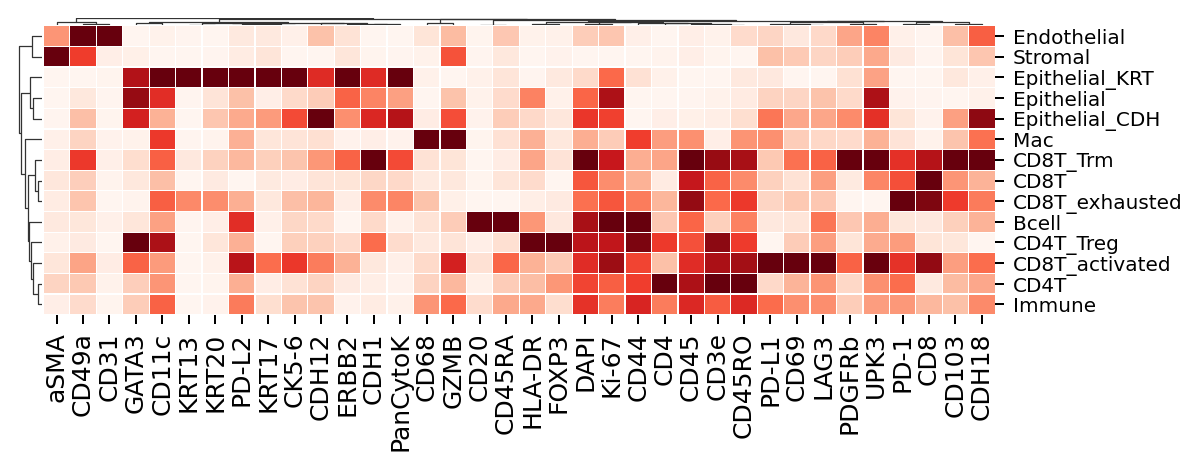

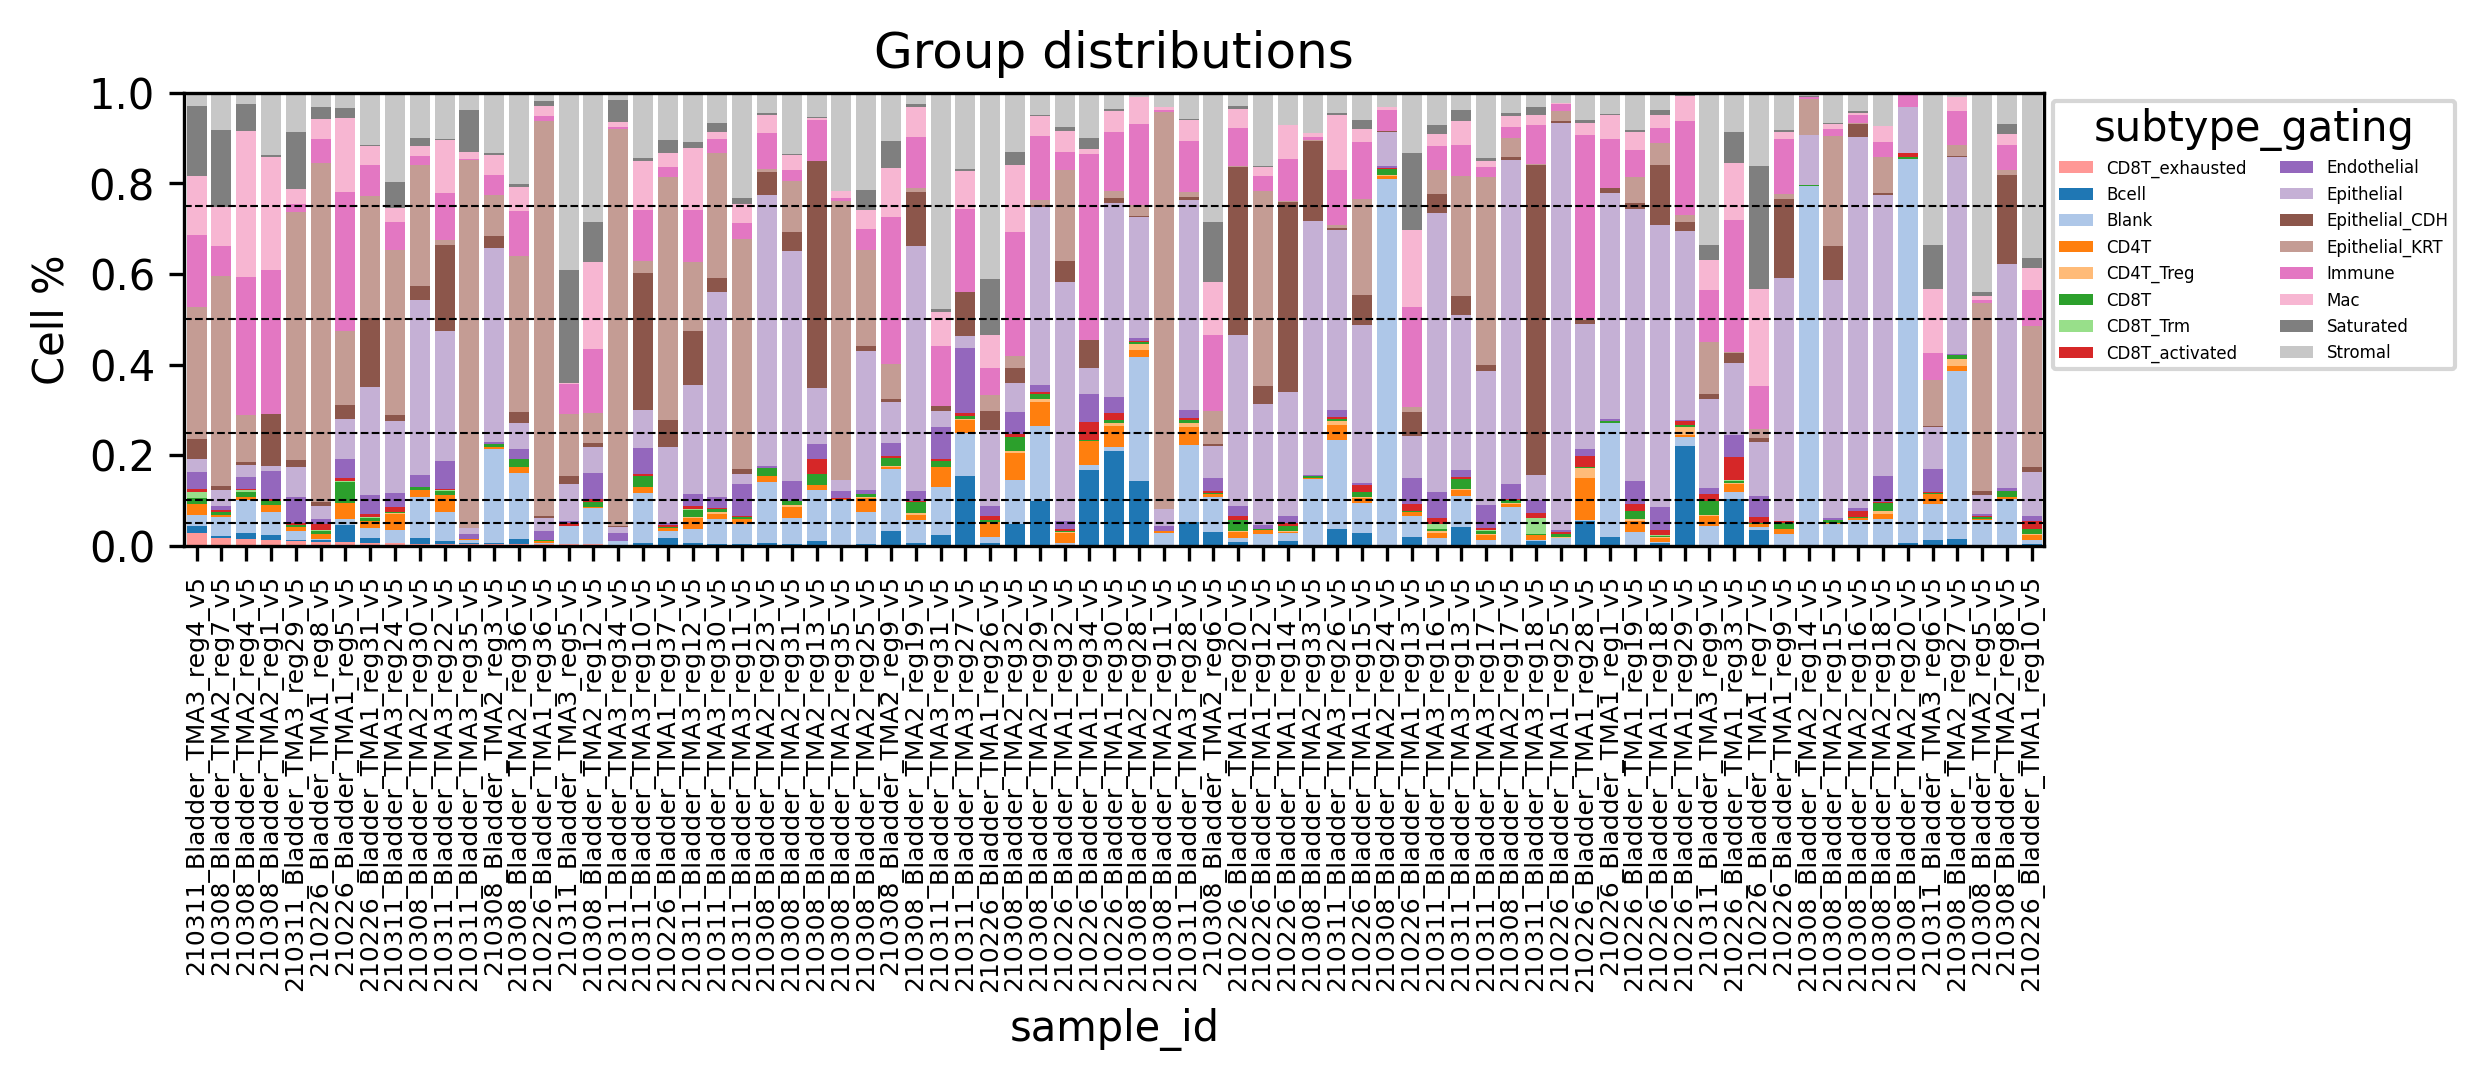

In [189]:
scrna.plot_heatmap(adata, 
                   summary_features, groupby='subtype_gating',
                   rm_groups=['Saturated', 'Blank'],
                   standard_scale=1, cmap='Reds', center_cmap=None, 
#                    z_score=1, cmap='RdBu_r', center_cmap=0, 
                   transpose=False,
                   replace_xticklabels={f:f.split('_')[0] for f in summary_features},
                   figsize=(7,4))

scrna.plot_group_percents(adata, 'subtype_gating', 'sample_id', sort_by='CD8T_exhausted')

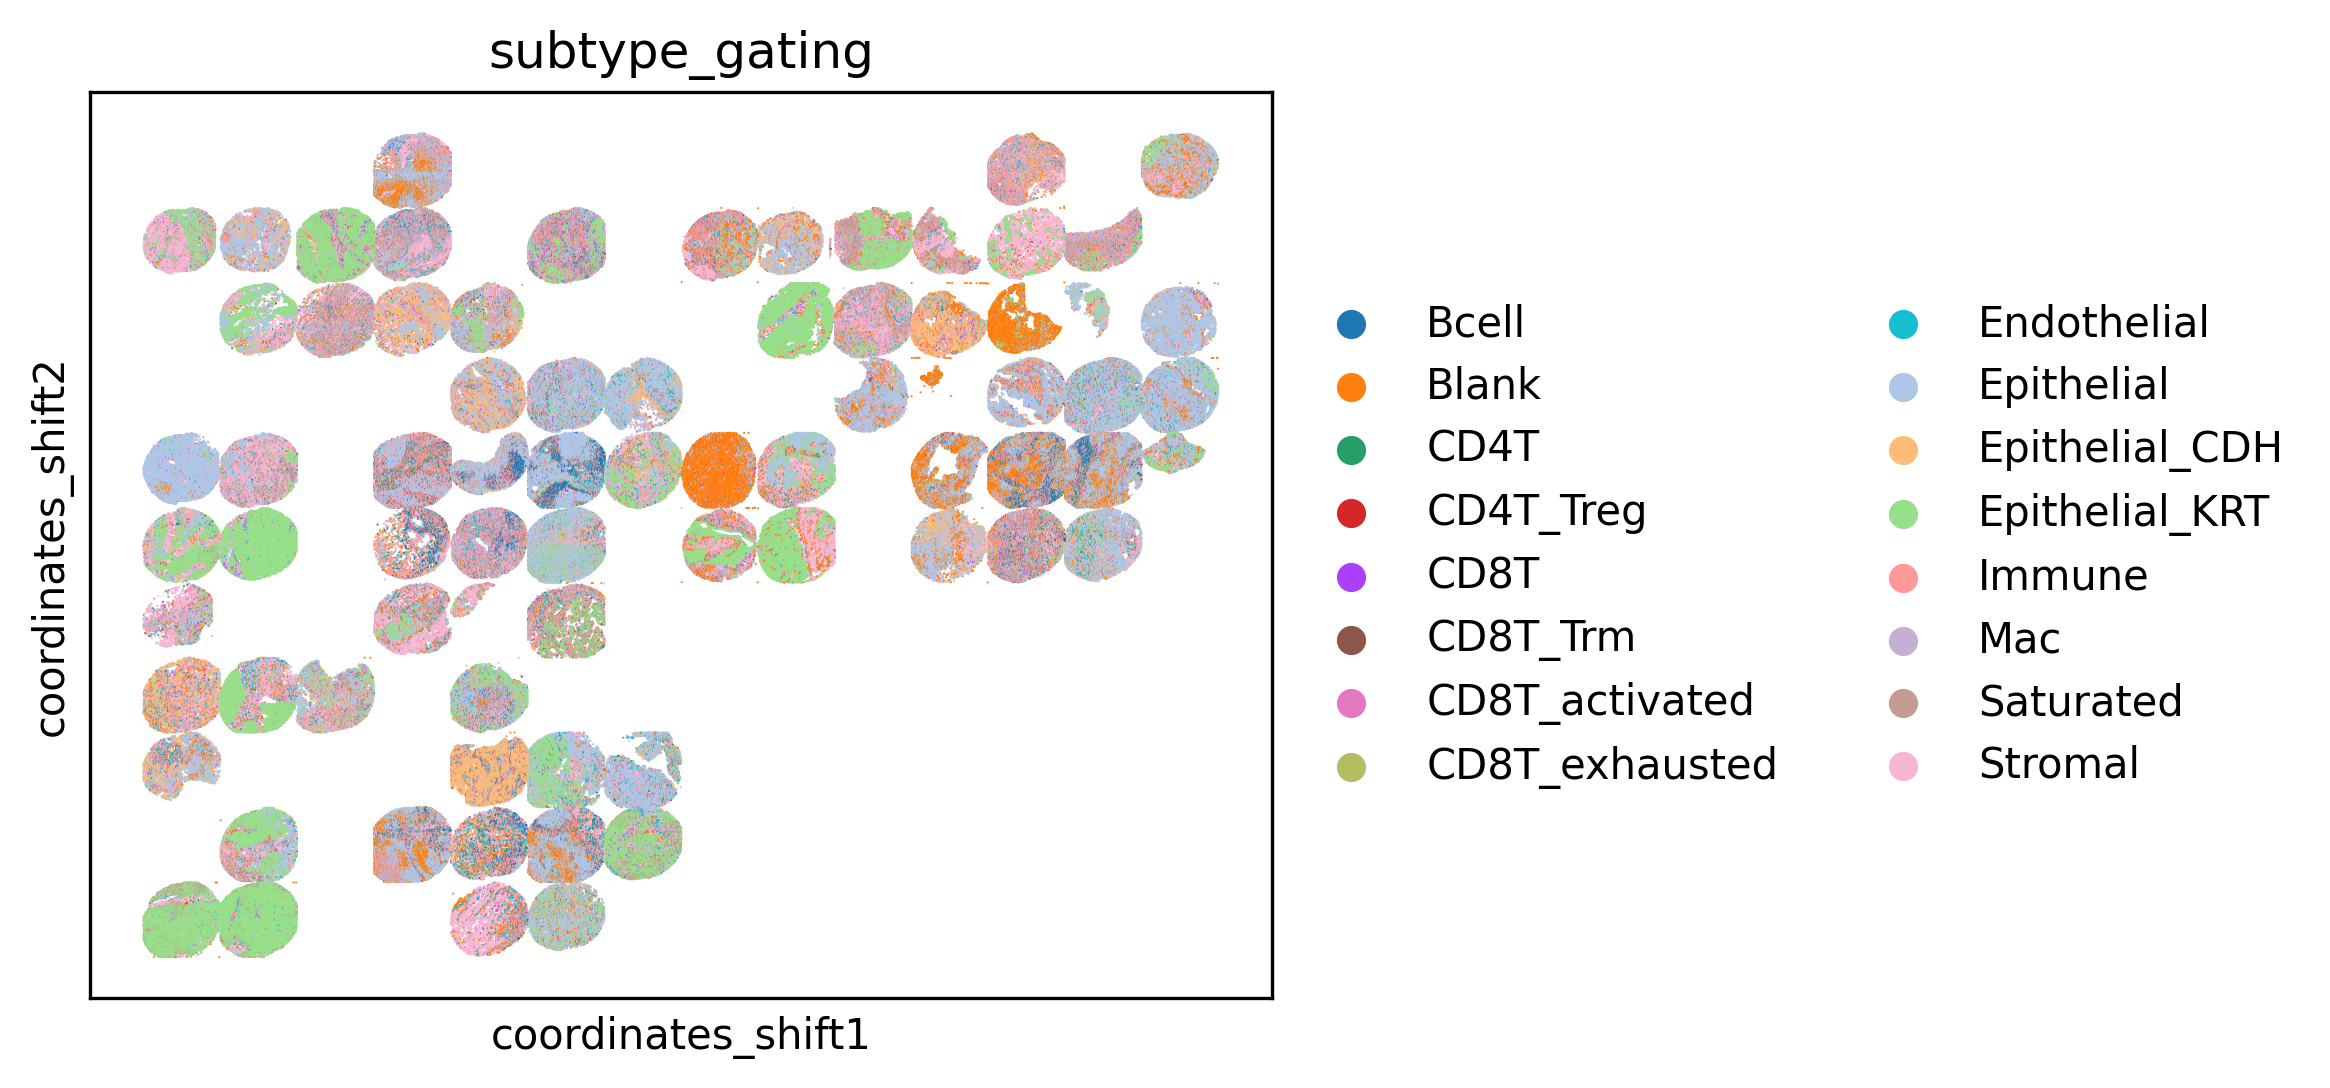

In [190]:
r = np.max(np.abs(adata.obsm['coordinates_shift']), axis=0)
r = r[0]/r[1]
plt.figure(figsize=(r*4,4), dpi=300) 
sc.pl.embedding(adata, basis='coordinates_shift', color='subtype_gating', 
                ax=plt.gca(), s=1, )

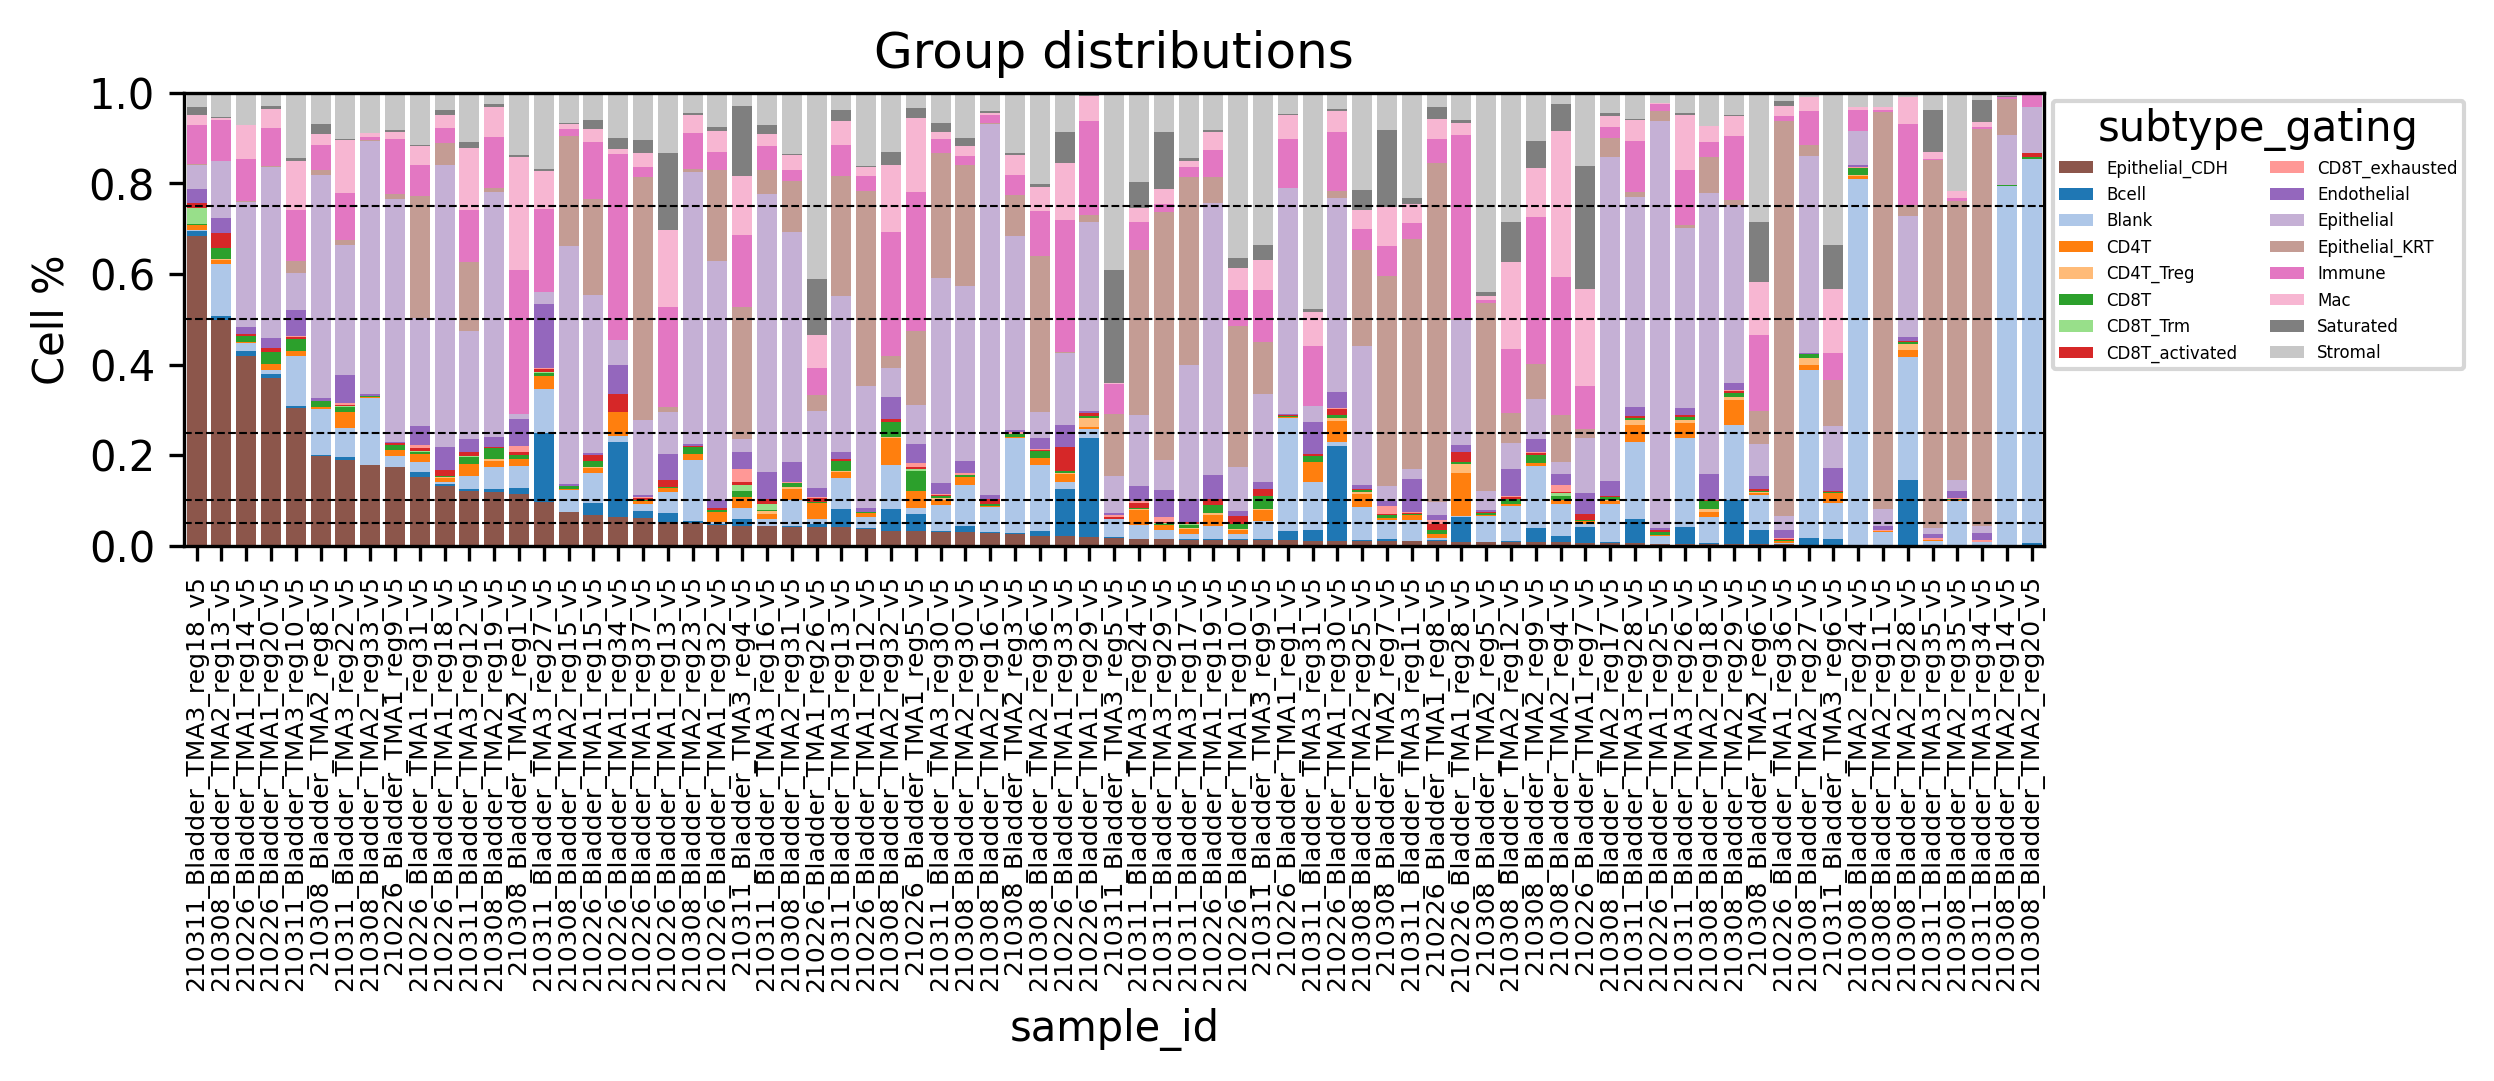

In [191]:
scrna.plot_group_percents(adata, 'subtype_gating', 'sample_id', sort_by='Epithelial_CDH')

In [192]:
adata.obs.subtype_gating.value_counts()

Epithelial        169644
Epithelial_KRT    107252
Immune             65835
Stromal            62110
Blank              53902
Mac                38861
Epithelial_CDH     38185
Saturated          19113
Endothelial        17441
Bcell              17427
CD4T               11274
CD8T                5609
CD8T_activated      4420
CD4T_Treg           1848
CD8T_exhausted      1404
CD8T_Trm             846
Name: subtype_gating, dtype: int64

In [193]:
features = [f'{c}_membrane_mean' for c in adata.uns['channels'] if c != 'DAPI']
features += [f'{c}_nuclei_mean' for c in adata.uns['channels'] if c != 'DAPI']
# features = [f'{c}_membrane_mean' for c in adata.uns['channels']]
# features += [f'{c}_nuclei_mean' for c in adata.uns['channels']]
# features += [f'{c}_nuclei_std' for c in adata.uns['channels']]
# subtype_features += [f'{c}_membrane_std' for c in marker_channels]

print(len(features))

70


In [194]:
np.random.seed(999)
training = ~adata.obs.subtype_gating.isin(['Blank', 'Saturated', 'Immune'])
pred_idx = adata.obs.subtype_gating.isin(['Blank', 'Saturated', 'Immune'])
from scipy import stats

rescue_predictions = []
for _ in range(10):
    X_train = adata[training, features].X.toarray()
#     X_train = np.log10(1+X_train)
    X_train = np.concatenate([np.log10(1+X_train), pct_features[training]], axis=1)
    Y_train = np.array(adata[training].obs['subtype_gating'])
    #print(X_train.shape, Y_train.shape)

    # Sample similar numbers of each group
    target = 500
    X_train_choice = []
    Y_train_choice = []
    X_heldout = []
    Y_heldout = []
    for c in np.unique(Y_train):
        z = Y_train==c
        #print(c,np.sum(z))
        xz = X_train[z,:]
        choice = np.random.choice(np.sum(z), min(np.sum(z), target), replace=False)
        mask = np.zeros(z.sum(),dtype=np.bool)
        mask[choice] = 1
        xz_ = xz[~mask,:]
        xz = xz[mask,:]
        X_train_choice.append(xz)
        Y_train_choice += [c]*min(np.sum(z), target)
        X_heldout.append(xz_)
        Y_heldout += [c]*np.sum(~mask)

    X_train = np.concatenate(X_train_choice, axis=0)
    Y_train = np.array(Y_train_choice)

    X_heldout = np.concatenate(X_heldout, axis=0)
    Y_heldout = np.array(Y_heldout)

    # X_train = np.log10(1+X_train)
    # scaler = MinMaxScaler()
    scaler = RobustScaler(with_centering=True, unit_variance=False)
    # X_heldout = np.log10(1+X_heldout)
    X_heldout = scaler.fit_transform(X_heldout)
    X_train = scaler.fit_transform(X_train)

    #print(X_train.shape, Y_train.shape)
    #print(X_heldout.shape, Y_heldout.shape)


    X_pred = adata[pred_idx, features].X.toarray()
#     X_pred = np.log10(1+X_pred)
    X_pred = np.concatenate([np.log10(1+X_pred), pct_features[pred_idx]], axis=1)
    X_pred = scaler.fit_transform(X_pred)
    Y_levels, Y_train_numeric = np.unique(Y_train, return_inverse=True)
    _, Y_heldout_numeric = np.unique(Y_heldout, return_inverse=True)
    #print(X_pred.shape)


    # cls = cuml.ensemble.RandomForestClassifier(max_features=1.0, n_estimators=50,
    #                                            use_experimental_backend=True,
    #                                            n_bins=16, max_batch_size=512,
    #                                            max_depth=16
    #                                           )

    cls = cuml.neighbors.KNeighborsClassifier(n_neighbors=20, weights='uniform', 
                                              verbose=False, output_type='numpy')

    # cls = RandomForestClassifier(max_features=1.0, n_estimators=150,
    #                              max_depth=36 , n_jobs=-1
    #                             )

    cls.fit(X_train, Y_train_numeric)
    
    Y_pred = cls.predict(X_pred)
    Y_pred_prob = cls.predict_proba(X_pred)

    Y_heldout_pred = cls.predict(X_heldout)

    Y_pred_mapped = np.zeros(Y_pred.shape[0], dtype='object')
    Y_heldout_pred_mapped = np.zeros(Y_heldout_pred.shape[0], dtype='object')
    for u in np.unique(Y_pred):
        u = int(u)
        #print(Y_levels[u], np.sum(Y_pred==u), np.sum(Y_heldout_pred==u), sep='\t')
        Y_pred_mapped[Y_pred==u] = Y_levels[u]
        Y_heldout_pred_mapped[Y_heldout_pred==u] = Y_levels[u]

    rescue_predictions.append(Y_pred)
    
# Y_pred_mapped = stats.mode(Y_pred_mapped)
# for u in Y_levels:
#     print(u, np.sum(Y_pred_mapped==u))


In [195]:
c = np.stack(rescue_predictions, axis=0)
m = stats.mode(c, axis=0)

for u in np.unique(m[0]):
    u = int(u)
    print(Y_levels[u], np.sum(m[0]==u), sep='\t')
    Y_pred_mapped[m[0].flatten()==u] = Y_levels[u]

Bcell	6138
CD4T	10468
CD4T_Treg	4160
CD8T	11828
CD8T_Trm	1442
CD8T_activated	22485
CD8T_exhausted	2225
Endothelial	1669
Epithelial	37930
Epithelial_CDH	9761
Epithelial_KRT	6174
Mac	13905
Stromal	10665


In [196]:
combined_labels = np.array(adata.obs.subtype_gating)
combined_labels[pred_idx] = Y_pred_mapped

# Reject immune rescues, accept epithelial/stromal
revert_labels = ['Bcell', 'CD4T', 'CD8T', 'CD8T_activated', 'CD4T_Treg', 'CD8T_Trm', 'CD8T_exhausted']
for l in revert_labels:
    ix = (combined_labels==l) & ((adata.obs.subtype_gating=='Saturated') | (adata.obs.subtype_gating=='Blank'))
    print(f'Reverting {l}: {np.sum(ix)}')
    combined_labels[ix] = 'filtered'

adata.obs['subtype_rescued'] = pd.Categorical(combined_labels)
adata.obs['subtype_rescued'].value_counts()

Reverting Bcell: 281
Reverting CD4T: 193
Reverting CD8T: 810
Reverting CD8T_activated: 12486
Reverting CD4T_Treg: 218
Reverting CD8T_Trm: 158
Reverting CD8T_exhausted: 238


Epithelial        207574
Epithelial_KRT    113426
Stromal            72775
Mac                52766
Epithelial_CDH     47946
Bcell              23284
CD4T               21549
Endothelial        19110
CD8T               16627
CD8T_activated     14419
filtered           14384
CD4T_Treg           5790
CD8T_exhausted      3391
CD8T_Trm            2130
Name: subtype_rescued, dtype: int64

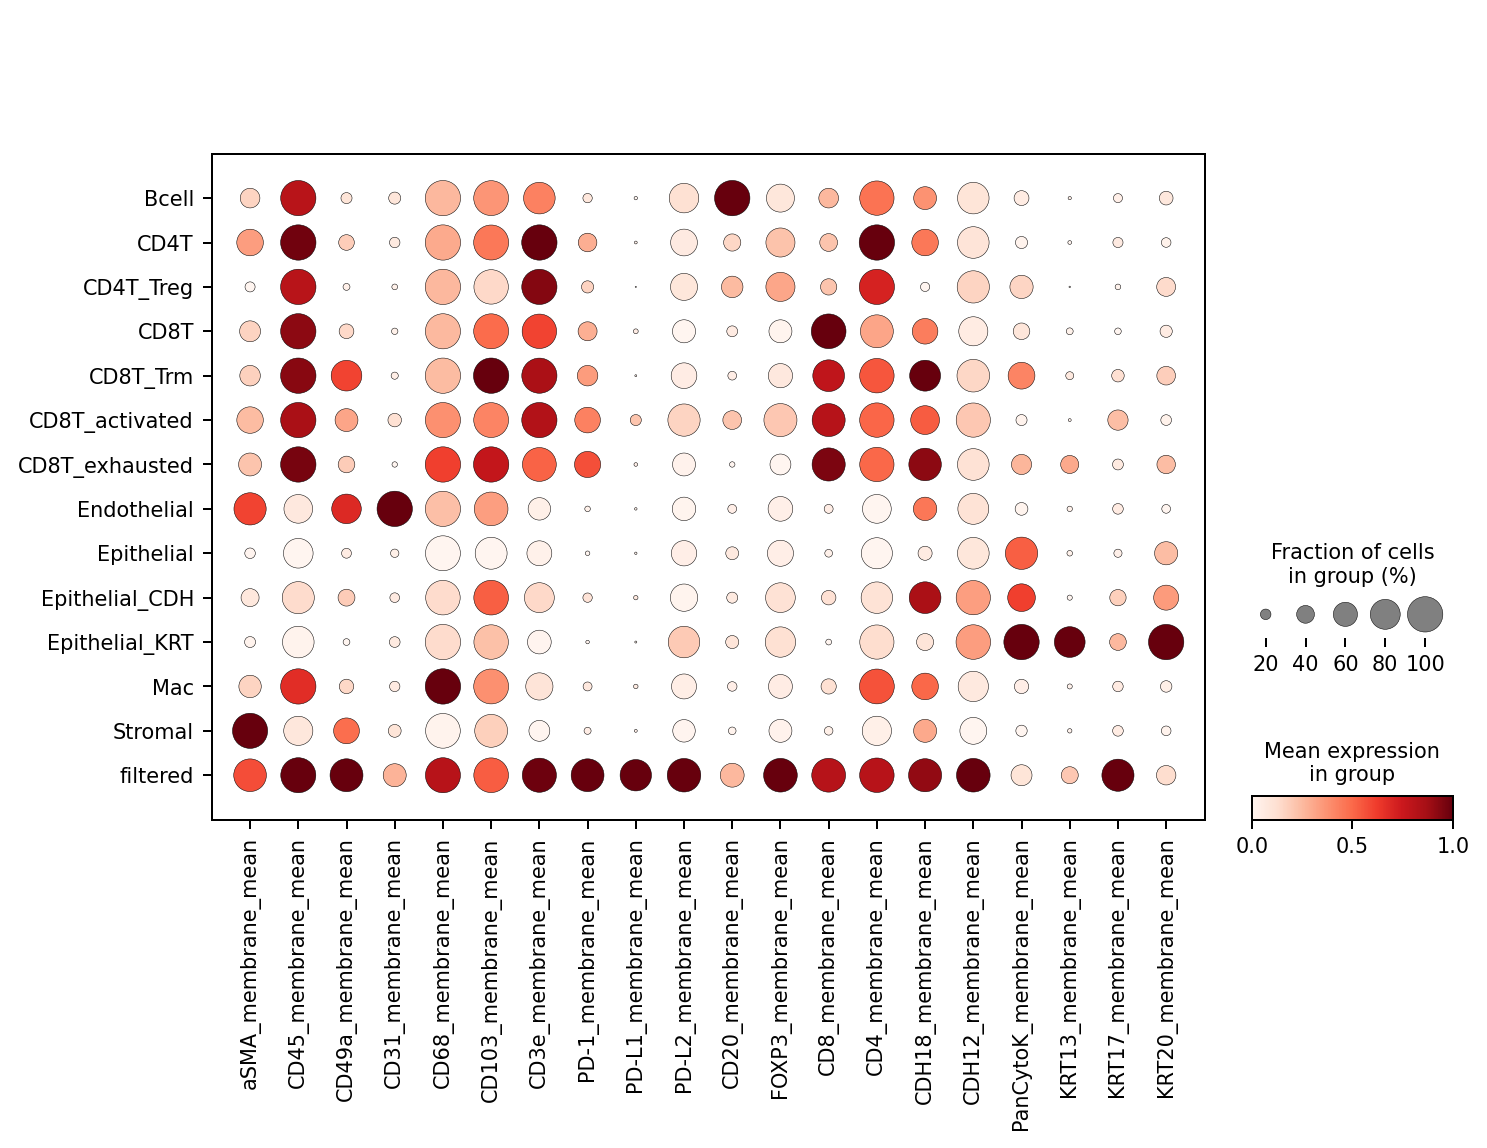

In [197]:
summary_features = ['aSMA', 'CD45', 'CD49a', 'CD31', 'CD68', 'CD103', 'CD3e',
                     'PD-1', 'PD-L1', 'PD-L2', 'CD20', 'FOXP3', 'CD8', 'CD4',
                     'CDH18', 'CDH12',
                    'PanCytoK', 'KRT13', 'KRT17', 'KRT20']
summary_features = [f'{m}_membrane_mean' for m in summary_features]
rcParams['figure.dpi'] = 180
sc.pl.dotplot(adata, 
              summary_features, groupby='subtype_rescued', standard_scale='var', log=True,
              expression_cutoff=2,
#               categories_order=[u for u in np.unique(adata.obs.subtype_gating) if u!='Saturated']
              )


/home/ingn/devel/scrna/scrna/plotting_utils.py:587: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(u_groups, fontsize=6, rotation=90)


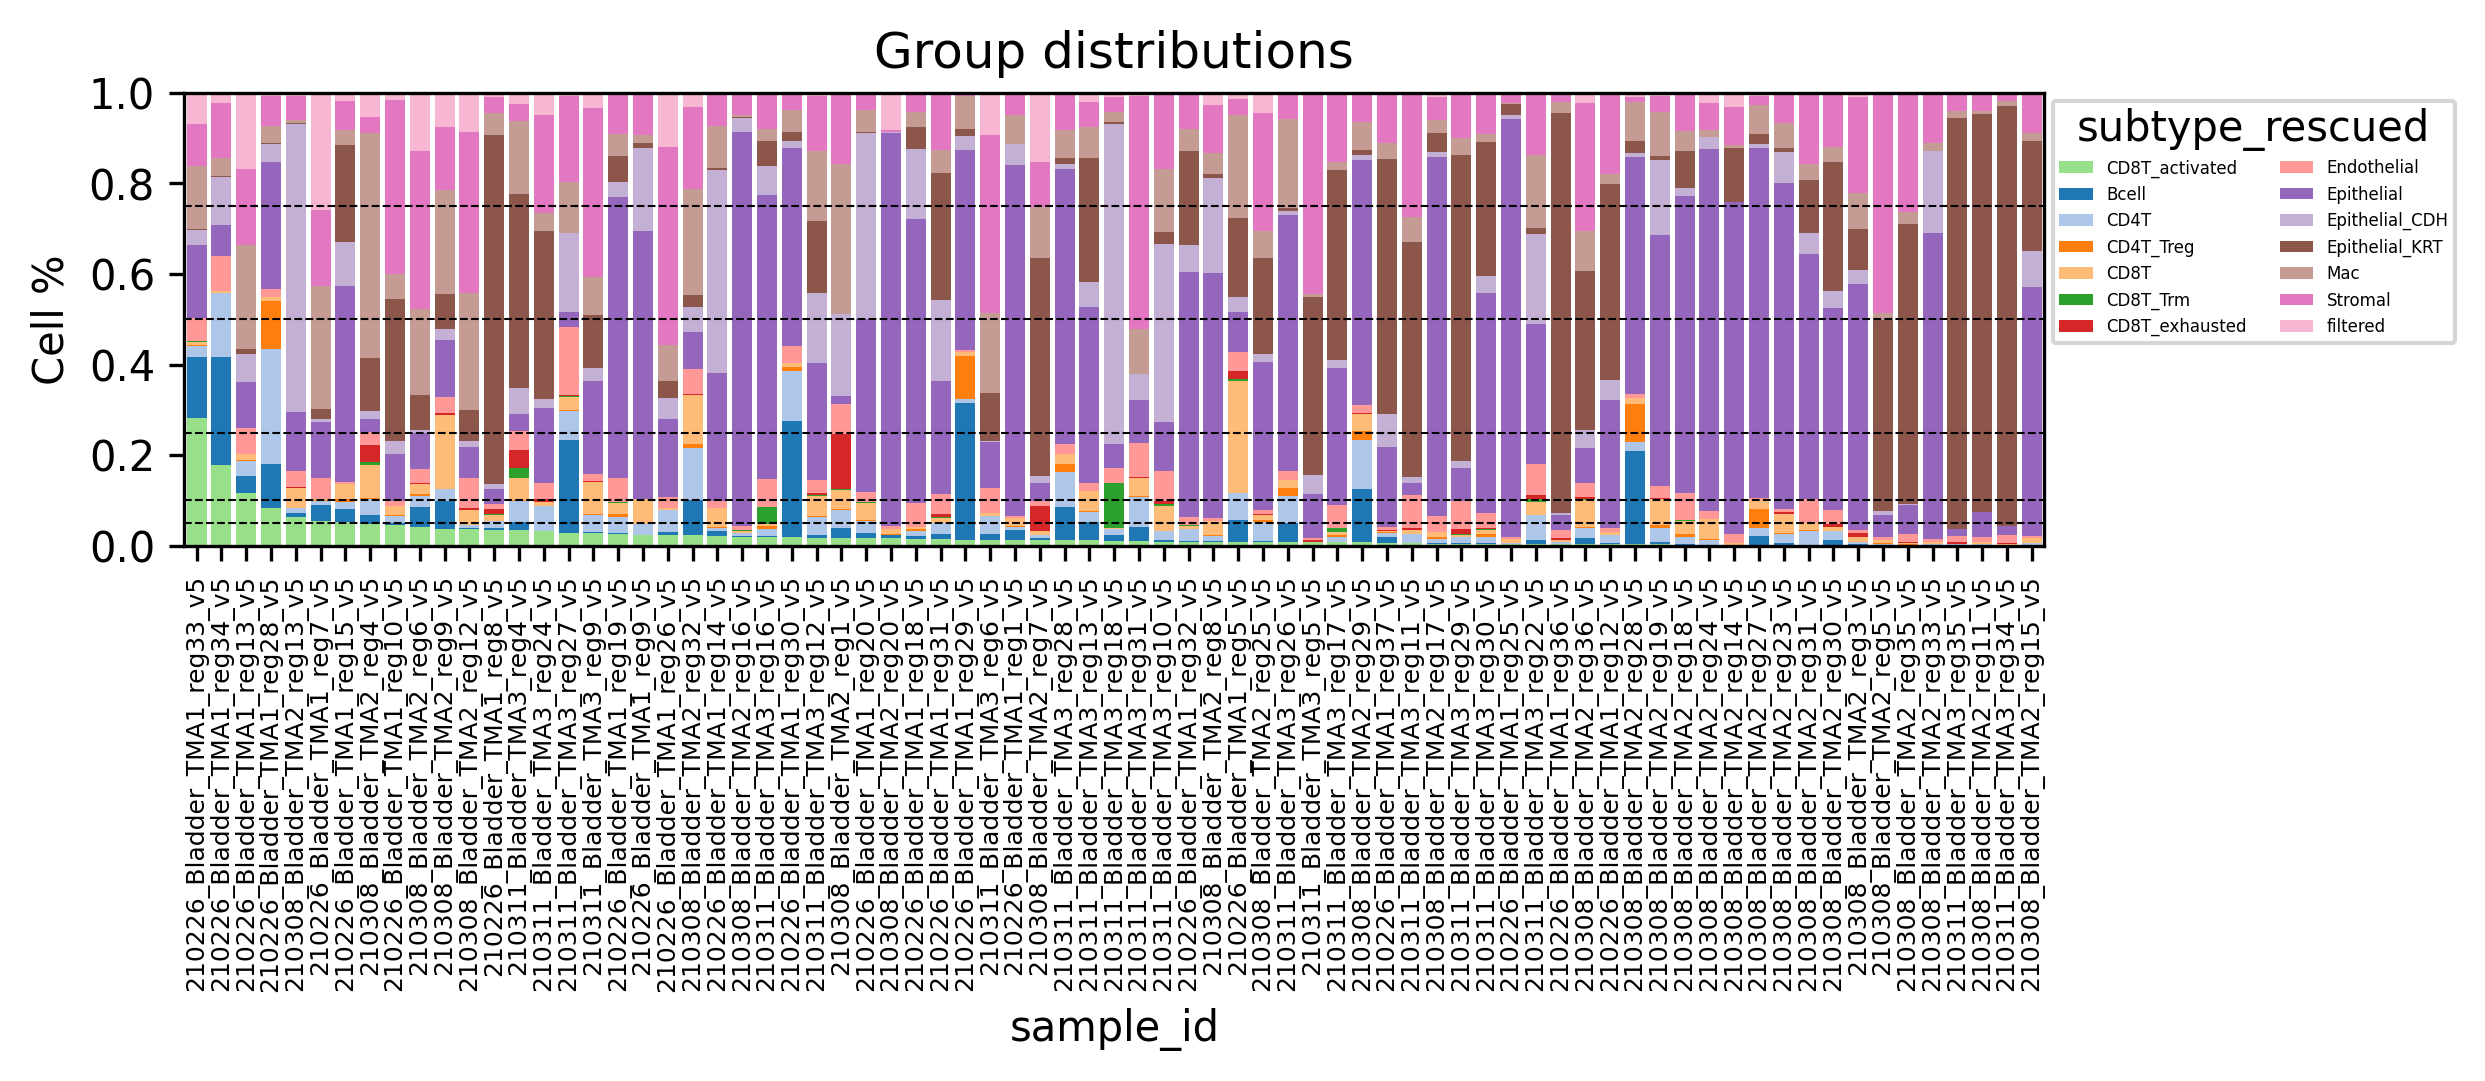

In [198]:
scrna.plot_group_percents(adata, 'subtype_rescued', 'sample_id', sort_by='CD8T_activated')

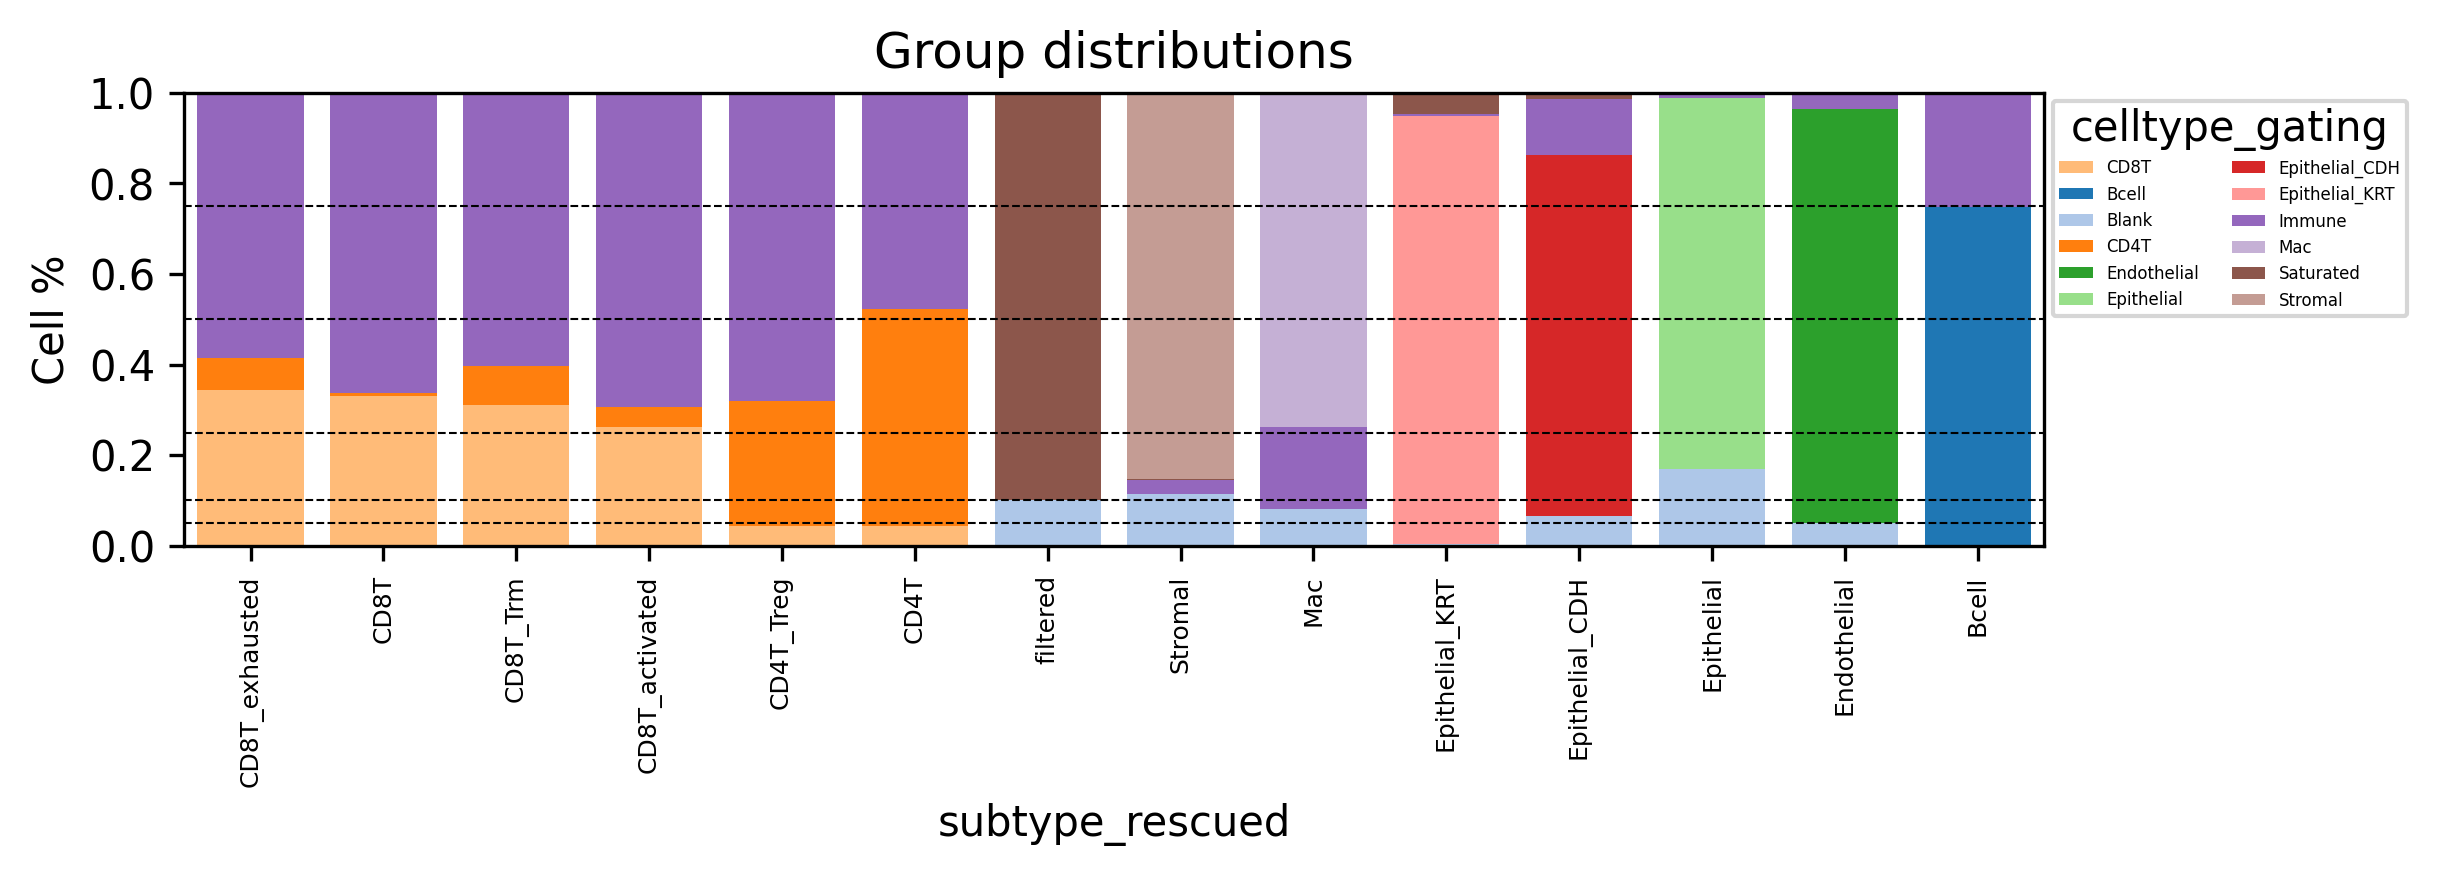

In [199]:
scrna.plot_group_percents(adata, 'celltype_gating', 'subtype_rescued', sort_by='CD8T')

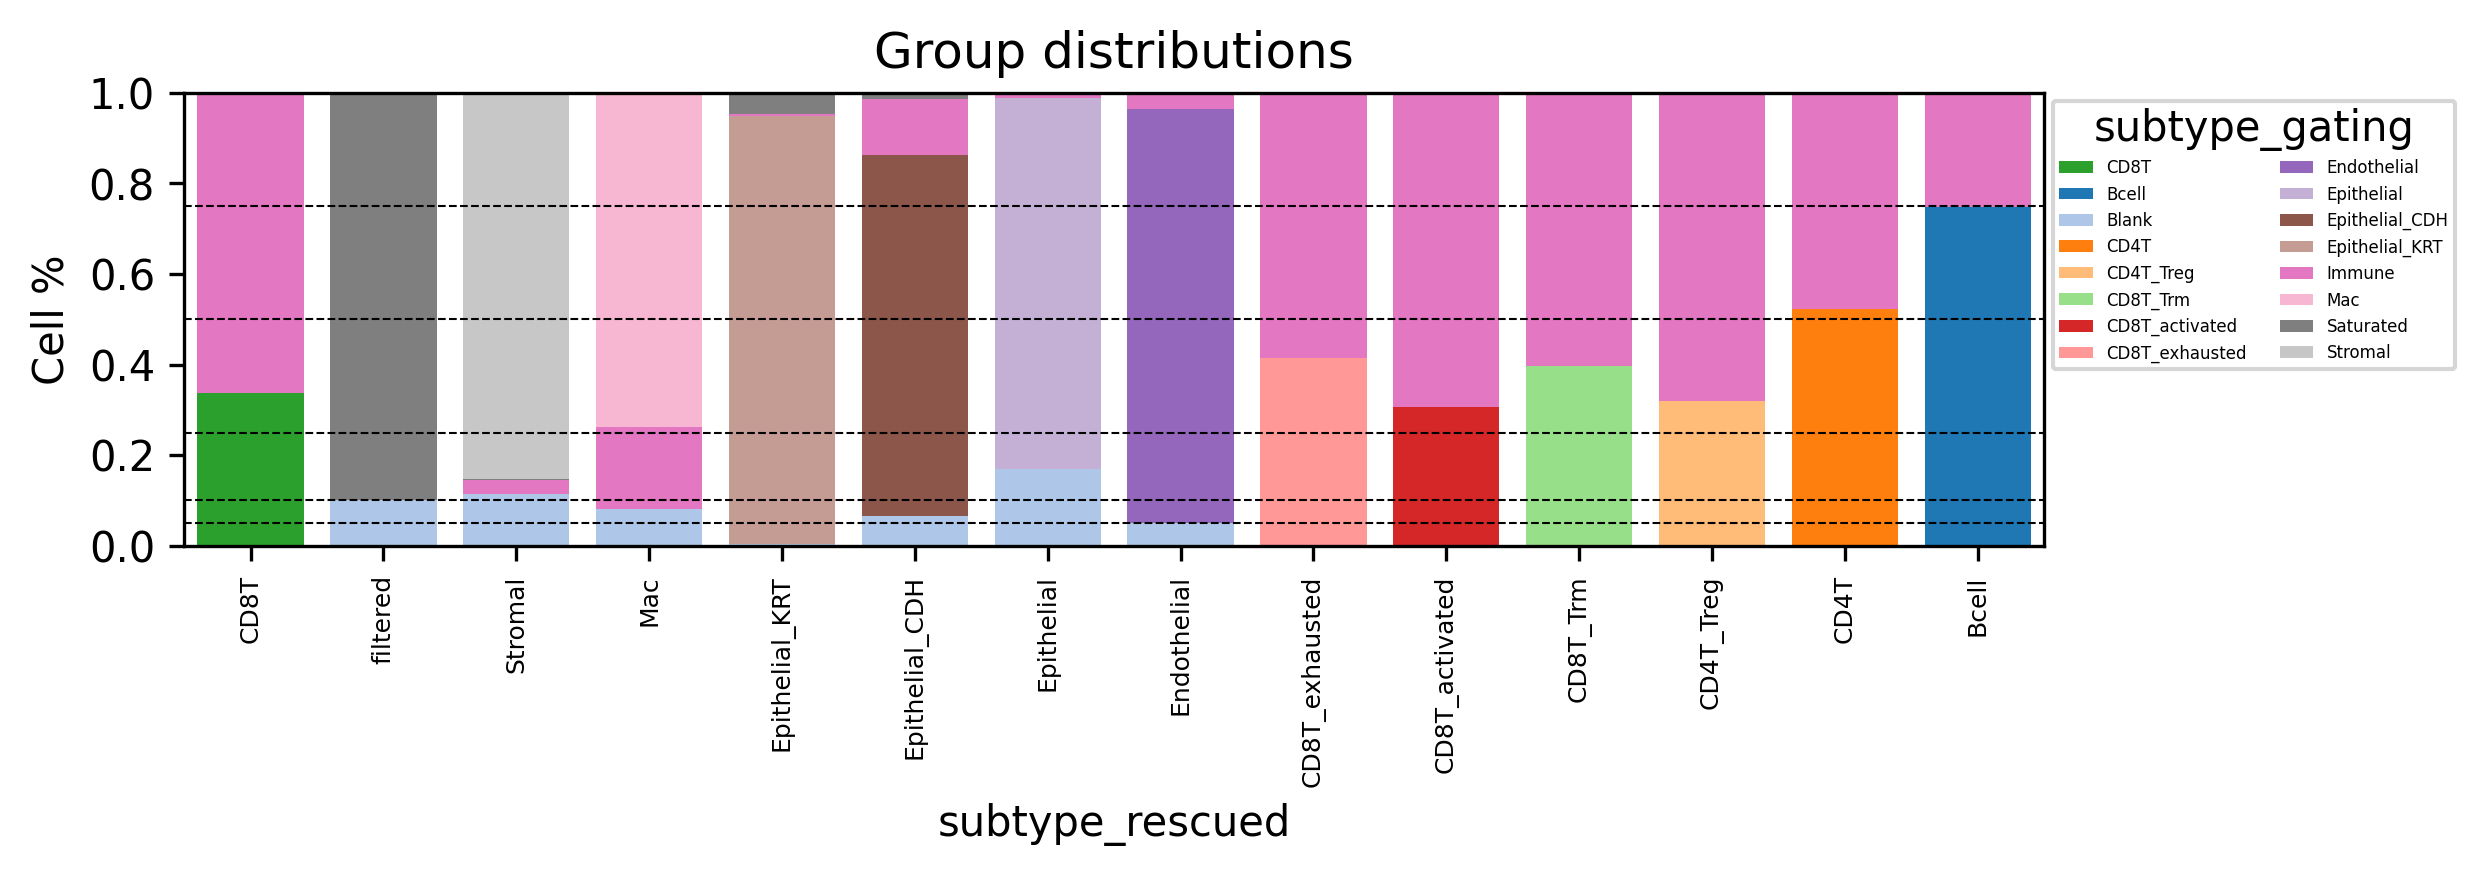

In [200]:
scrna.plot_group_percents(adata, 'subtype_gating', 'subtype_rescued', sort_by='CD8T')

In [201]:
y = np.array(adata.obs.subtype_rescued)
y[cell_sets['low_DAPI']] = 'filtered'
# y[adata.obs.subtype_gating=='Saturated'] = 'filtered'
adata.obs['subtype_rescued'] = pd.Categorical(y)

In [202]:
adata.obs.subtype_rescued.value_counts()

Epithelial        206809
Epithelial_KRT    112822
Stromal            71863
Mac                52689
Epithelial_CDH     47905
Bcell              23278
CD4T               21543
Endothelial        19081
filtered           16844
CD8T               16614
CD8T_activated     14412
CD4T_Treg           5790
CD8T_exhausted      3391
CD8T_Trm            2130
Name: subtype_rescued, dtype: int64

In [203]:
labels = np.array(adata.obs.subtype_rescued)
labels[labels=='Epithelial_KRT'] = 'Epithelial'
adata.obs['subtype'] = pd.Categorical(labels)

labels = np.array(adata.obs.subtype_rescued)
labels[labels == 'Epithelial_KRT'] = 'Epithelial'
labels[labels == 'CD8T_exhausted'] = 'CD8T'
labels[labels == 'CD8T_Trm'] = 'CD8T'
labels[labels == 'CD8T_activated'] = 'CD8T'
labels[labels == 'CD4T_Treg'] = 'CD4T'
adata.obs['celltype'] = pd.Categorical(labels)

In [204]:
adata.obs.subtype.value_counts()

Epithelial        319631
Stromal            71863
Mac                52689
Epithelial_CDH     47905
Bcell              23278
CD4T               21543
Endothelial        19081
filtered           16844
CD8T               16614
CD8T_activated     14412
CD4T_Treg           5790
CD8T_exhausted      3391
CD8T_Trm            2130
Name: subtype, dtype: int64

6249
45392


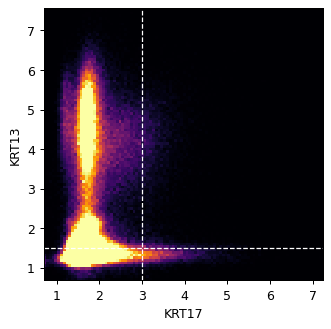

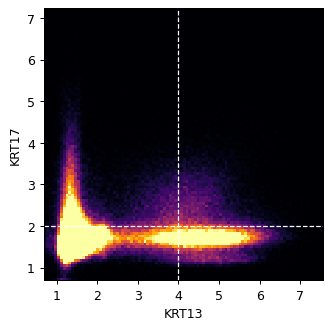

In [205]:
f1 = 'KRT17'
f2 = 'KRT13'
epithelial_KRT17 = feature_histogram(adata,f1,f2,adata.obs.celltype=='Epithelial',
                      vmax=0.1,v1cut=3,v2cut=1.5,f1_fn=np.sum, save='gate_figures/epithelial_KRT17.svg') 
# subtype_sets['CD8T_exhausted'] = CD8T_exhausted

f1 = 'KRT13'
f2 = 'KRT17'
epithelial_KRT13 = feature_histogram(adata,f1,f2,adata.obs.celltype=='Epithelial',
                      vmax=0.1,v1cut=4,v2cut=2,f1_fn=np.sum, save='gate_figures/epithelial_KRT13.svg') 

labels = np.array(adata.obs.subtype)
labels[epithelial_KRT13] = 'Epithelial_KRT13'
labels[epithelial_KRT17] = 'Epithelial_KRT17'
adata.obs['subtype'] = pd.Categorical(labels)

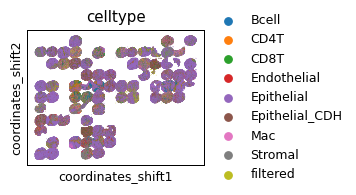

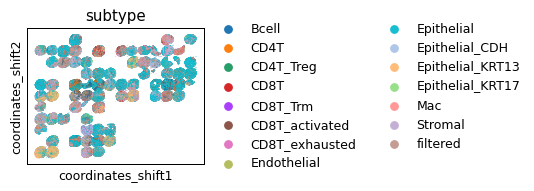

In [92]:
r = np.max(np.abs(adata.obsm['coordinates_shift']), axis=0)
r = r[0]/r[1]
plt.figure(figsize=(r*2,2), dpi=90) 
sc.pl.embedding(adata, basis='coordinates_shift', color='celltype', 
                ax=plt.gca(), s=1, )

plt.figure(figsize=(r*2,2), dpi=90) 
sc.pl.embedding(adata, basis='coordinates_shift', color='subtype', 
                ax=plt.gca(), s=1, )

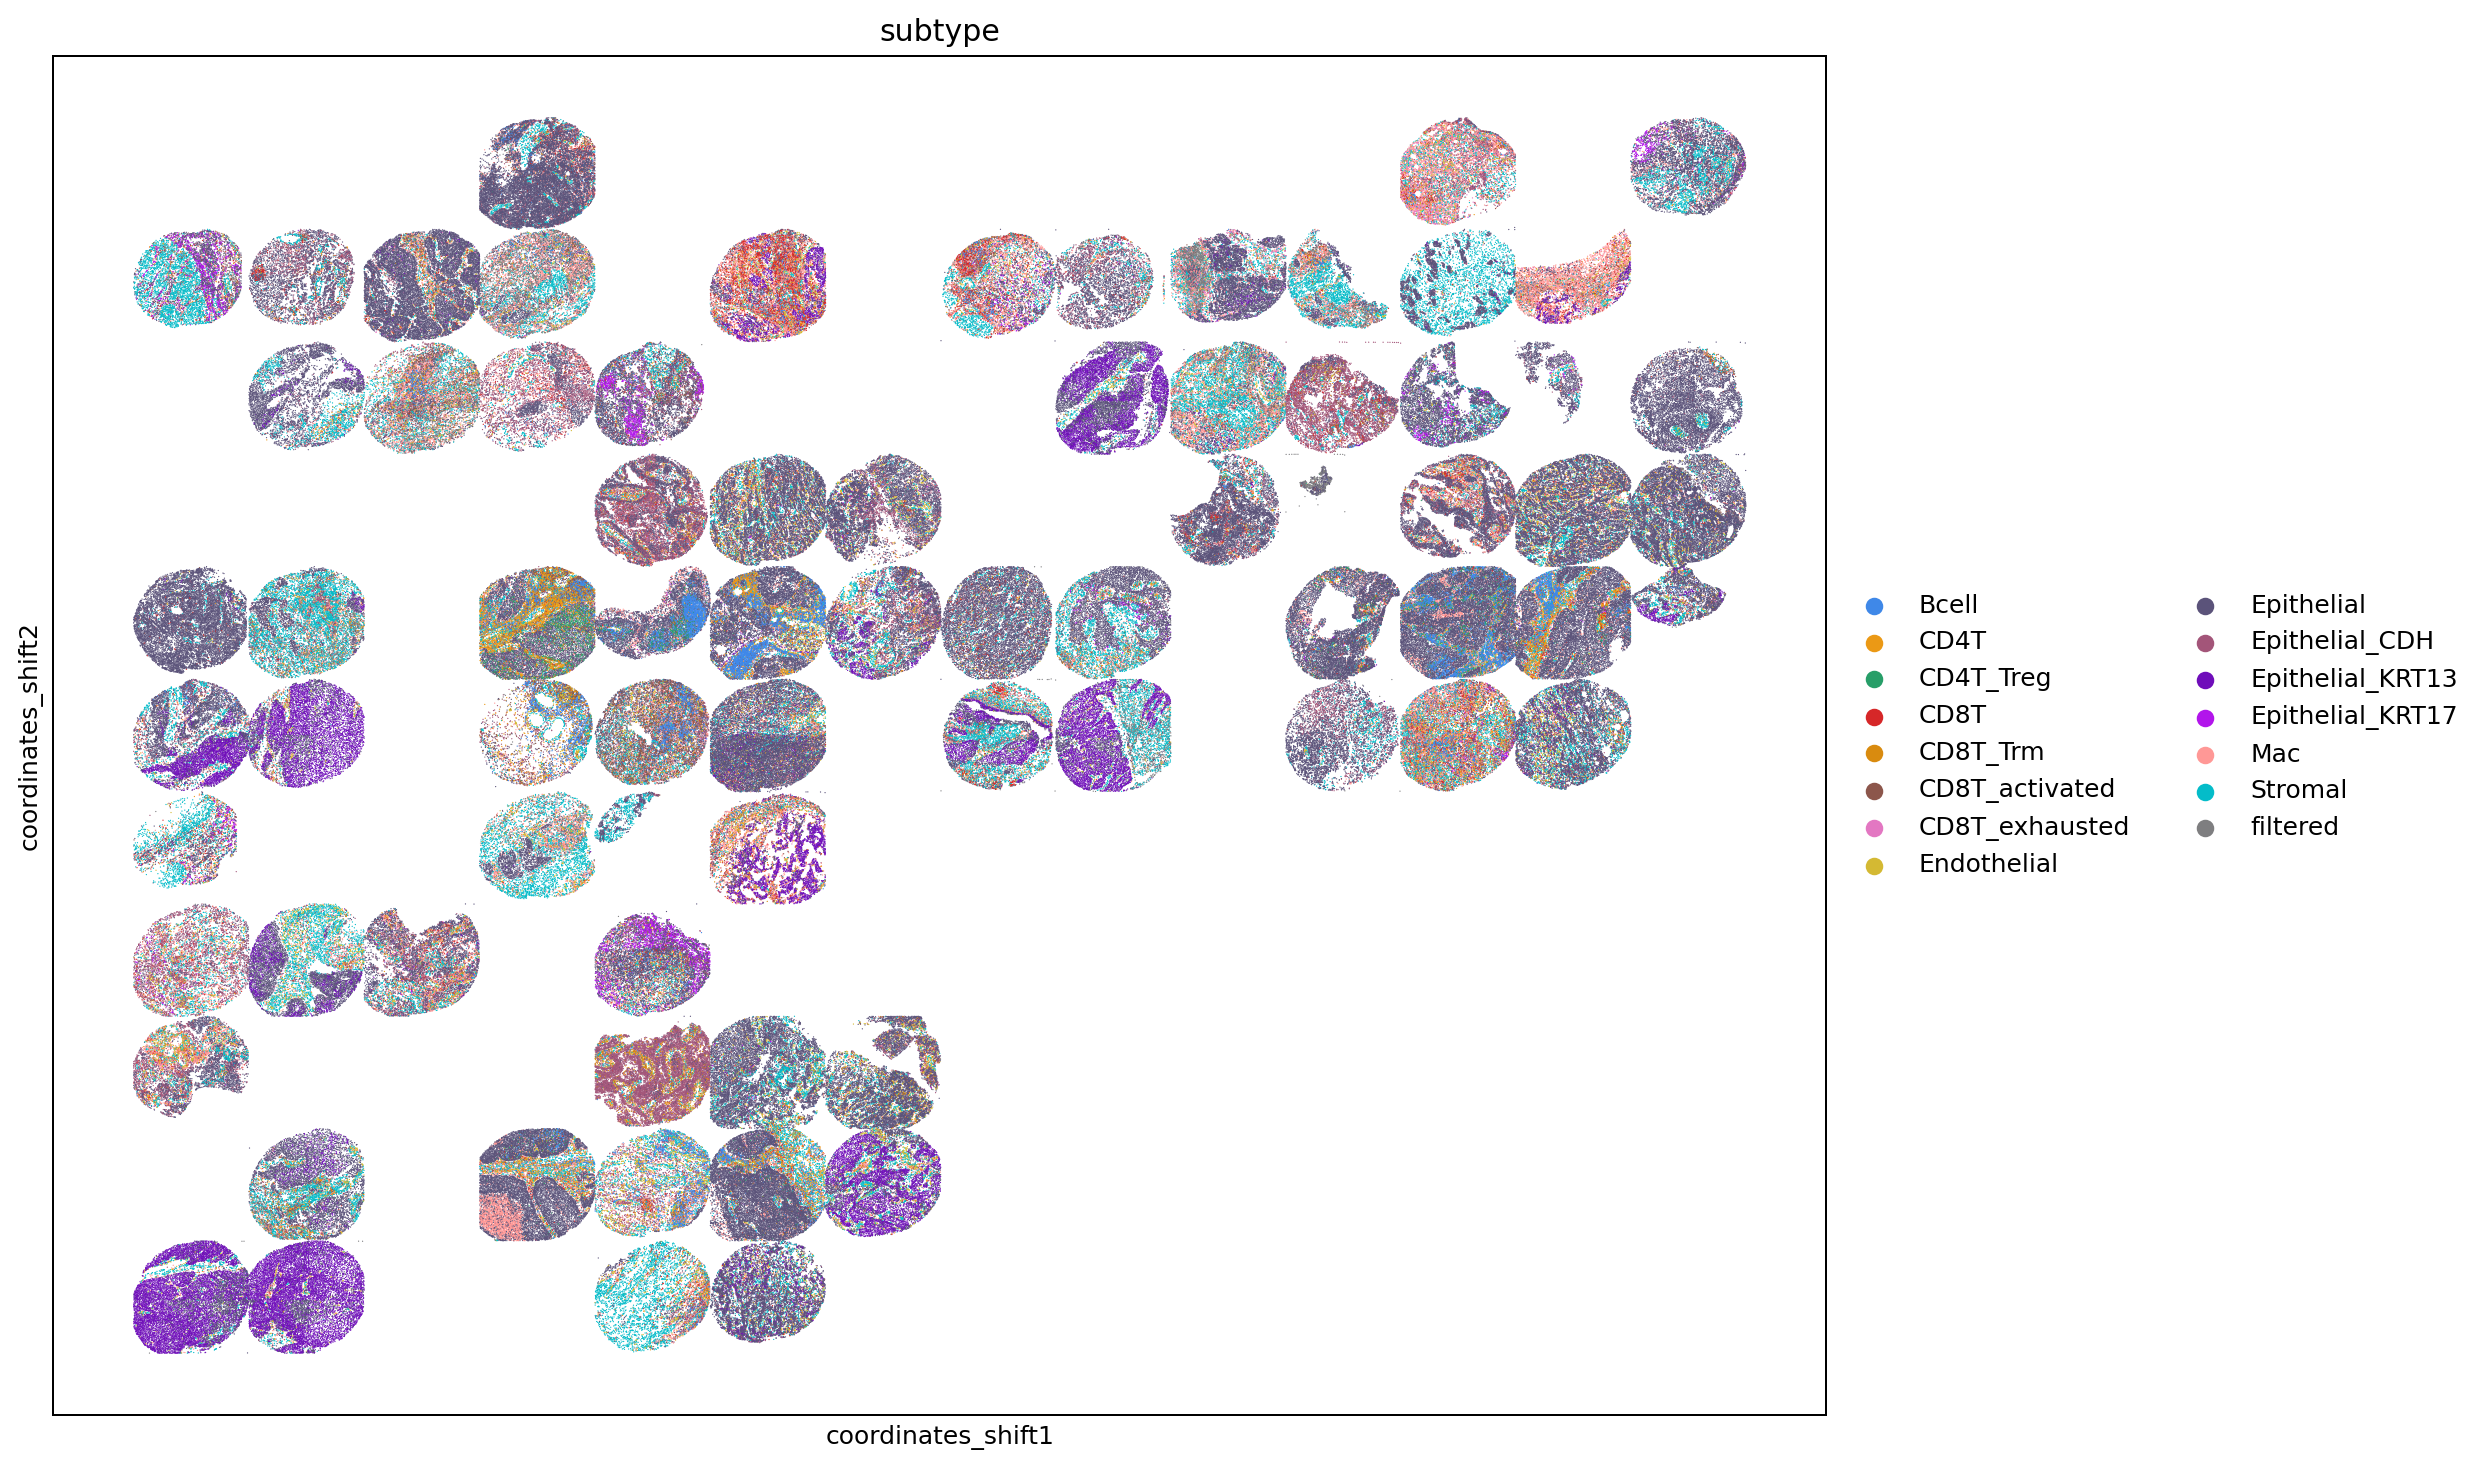

In [93]:
celltype_colors = {u: c for u, c in zip(np.unique(adata.obs.celltype), adata.uns['celltype_colors'])}
subtype_colors = {u: c for u, c in zip(np.unique(adata.obs.subtype), adata.uns['subtype_colors'])}

celltype_colors['Bcell'] = '#3f88e8'
celltype_colors['CD4T'] = '#eb9915'
celltype_colors['Endothelial'] = '#d4b933'
celltype_colors['Epithelial'] = '#5b537a'
celltype_colors['Epithelial_CDH'] = '#a35579'
celltype_colors['Stromal'] = '#04bcc9'
celltype_colors['filtered'] = '#7e7e80'

subtype_colors['Bcell'] = '#3f88e8'
subtype_colors['CD4T'] = '#eb9915'
subtype_colors['Endothelial'] = '#d4b933'
subtype_colors['Epithelial'] = '#5b537a'
subtype_colors['Epithelial_KRT13'] = '#6f0dba'
subtype_colors['Epithelial_KRT17'] = '#b215eb'
subtype_colors['Epithelial_CDH'] = '#a35579'
subtype_colors['Stromal'] = '#04bcc9'
subtype_colors['filtered'] = '#7e7e80'
subtype_colors['CD8T_Trm'] = '#d98b0f'

adata.uns['celltype_colors'] = [v for k,v in celltype_colors.items()]
adata.uns['subtype_colors'] = [v for k,v in subtype_colors.items()]


r = np.max(np.abs(adata.obsm['coordinates_shift']), axis=0)
r = r[0]/r[1]
# plt.figure(figsize=(r*5,5), dpi=180) 
# sc.pl.embedding(adata, basis='coordinates_shift', color='celltype', 
#                 ax=plt.gca(), s=1, )

plt.figure(figsize=(r*10,10), dpi=180) 
sc.pl.embedding(adata, basis='coordinates_shift', color='subtype', 
                ax=plt.gca(), s=1, )

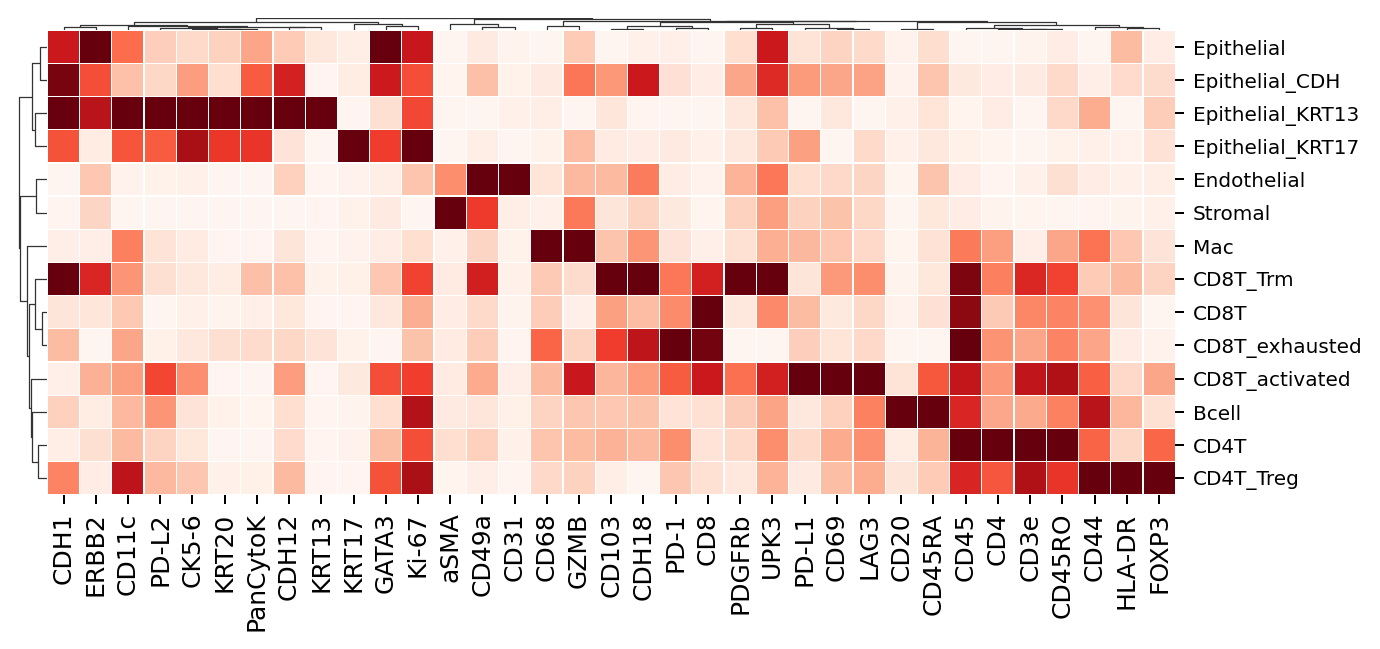

In [94]:
features = [f'{x}_membrane_mean' for x in adata.uns['channels'] if x != 'DAPI'] 
rcParams['figure.dpi'] = 90
scrna.plot_heatmap(adata, features, groupby='subtype', 
                   rm_groups=['filtered'],
                   standard_scale=1, transpose=False, 
                   replace_xticklabels={f:f.split('_')[0] for f in features},
                   cmap='Reds', figsize=(8,5))